This notebook is made to explore ways to take an existing sleap project and perform preprocessing on the frames to make tracking easier

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

/home/durrieu/miniforge3/envs/opencv_cuda/lib/python3.12/site-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/durrieu/miniforge3/envs/opencv_cuda/lib/python3.12/site-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/durrieu/miniforge3/envs/opencv_cuda/lib/python3.12/site-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/durrieu/miniforge3/envs/opencv_cuda/lib/python3.12/site-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Matplotlib is building

# Testing preprocessing options on an example video

In [4]:
def extract_frame(video_path):
    """Extract the last frame from the video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Move to the last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1)

    # Read the last frame
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame from video {video_path}")
        return None

    cap.release()
    return frame

def generate_grid(folder_path, preview=False, overwrite=False):
    folder_path = Path(folder_path)

    # print(f"Generating grid image for {folder_path.name}")

    frames = []
    paths = []

    # Iterate over all video files in the folder
    for video_file in folder_path.rglob("*.mp4"):  # Adjust the pattern if needed
        frame = extract_frame(video_file)
        if frame is not None:
            frames.append(frame)
            paths.append(video_file)

    return frames, paths

def plot_grid(frames, paths):
    # Set the number of rows and columns for the grid
    nrows = 9
    ncols = 6

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))

    # Loop over the frames and video paths
    for i, (frame, video_path) in enumerate(zip(frames, paths)):
        # Get the row and column index for this subplot
        row = i // ncols
        col = i % ncols

        # Plot the frame on this subplot
        try:
            axs[row, col].imshow(frame, cmap="gray", vmin=0, vmax=255)
        except:
            print(f"Error: Could not plot frame {i} for video {video_path}")
            continue

    # Remove the axis of each subplot and draw them closer together
    for ax in axs.flat:
        ax.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [5]:
frames, paths = generate_grid("/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231205_TNT_Fine_1_Videos_Tracked")

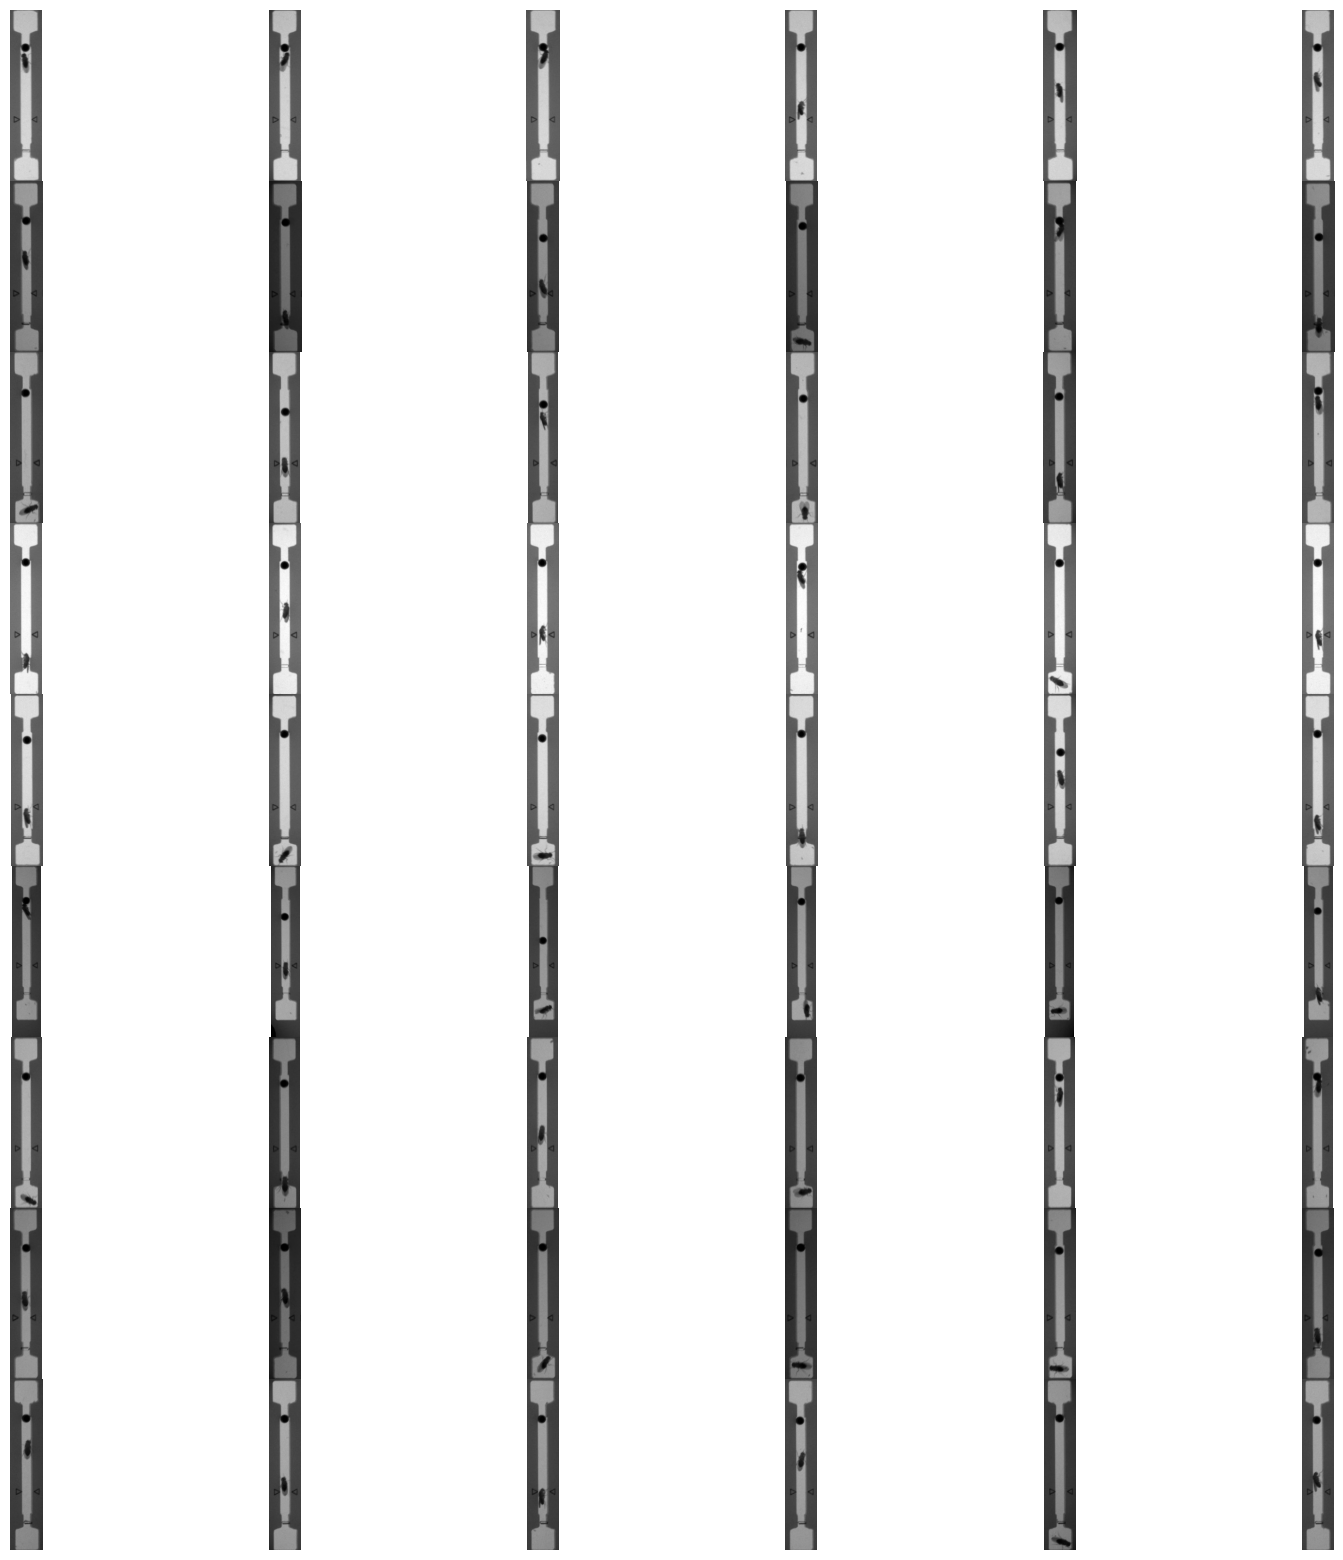

In [6]:
plot_grid(frames, paths)

In [27]:
# Now let's apply histogram equalization over the frames


def compute_global_histogram(frames):
    """Compute the global histogram for all frames."""
    global_hist = np.zeros(256, dtype=np.float32)
    for frame in frames:
        if len(frame.shape) == 3:  # Convert to grayscale if needed
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([frame], [0], None, [256], [0, 256])
        global_hist += hist.flatten()
    return global_hist


def compute_global_cdf(global_hist):
    """Compute the global CDF from the global histogram."""
    cdf = global_hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]  # Normalize to [0, 255]
    return cdf_normalized


def apply_global_histogram_equalization(frame, global_cdf):
    """Apply global histogram equalization to a single frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    equalized_frame = cv2.LUT(frame, global_cdf.astype(np.uint8))
    return equalized_frame

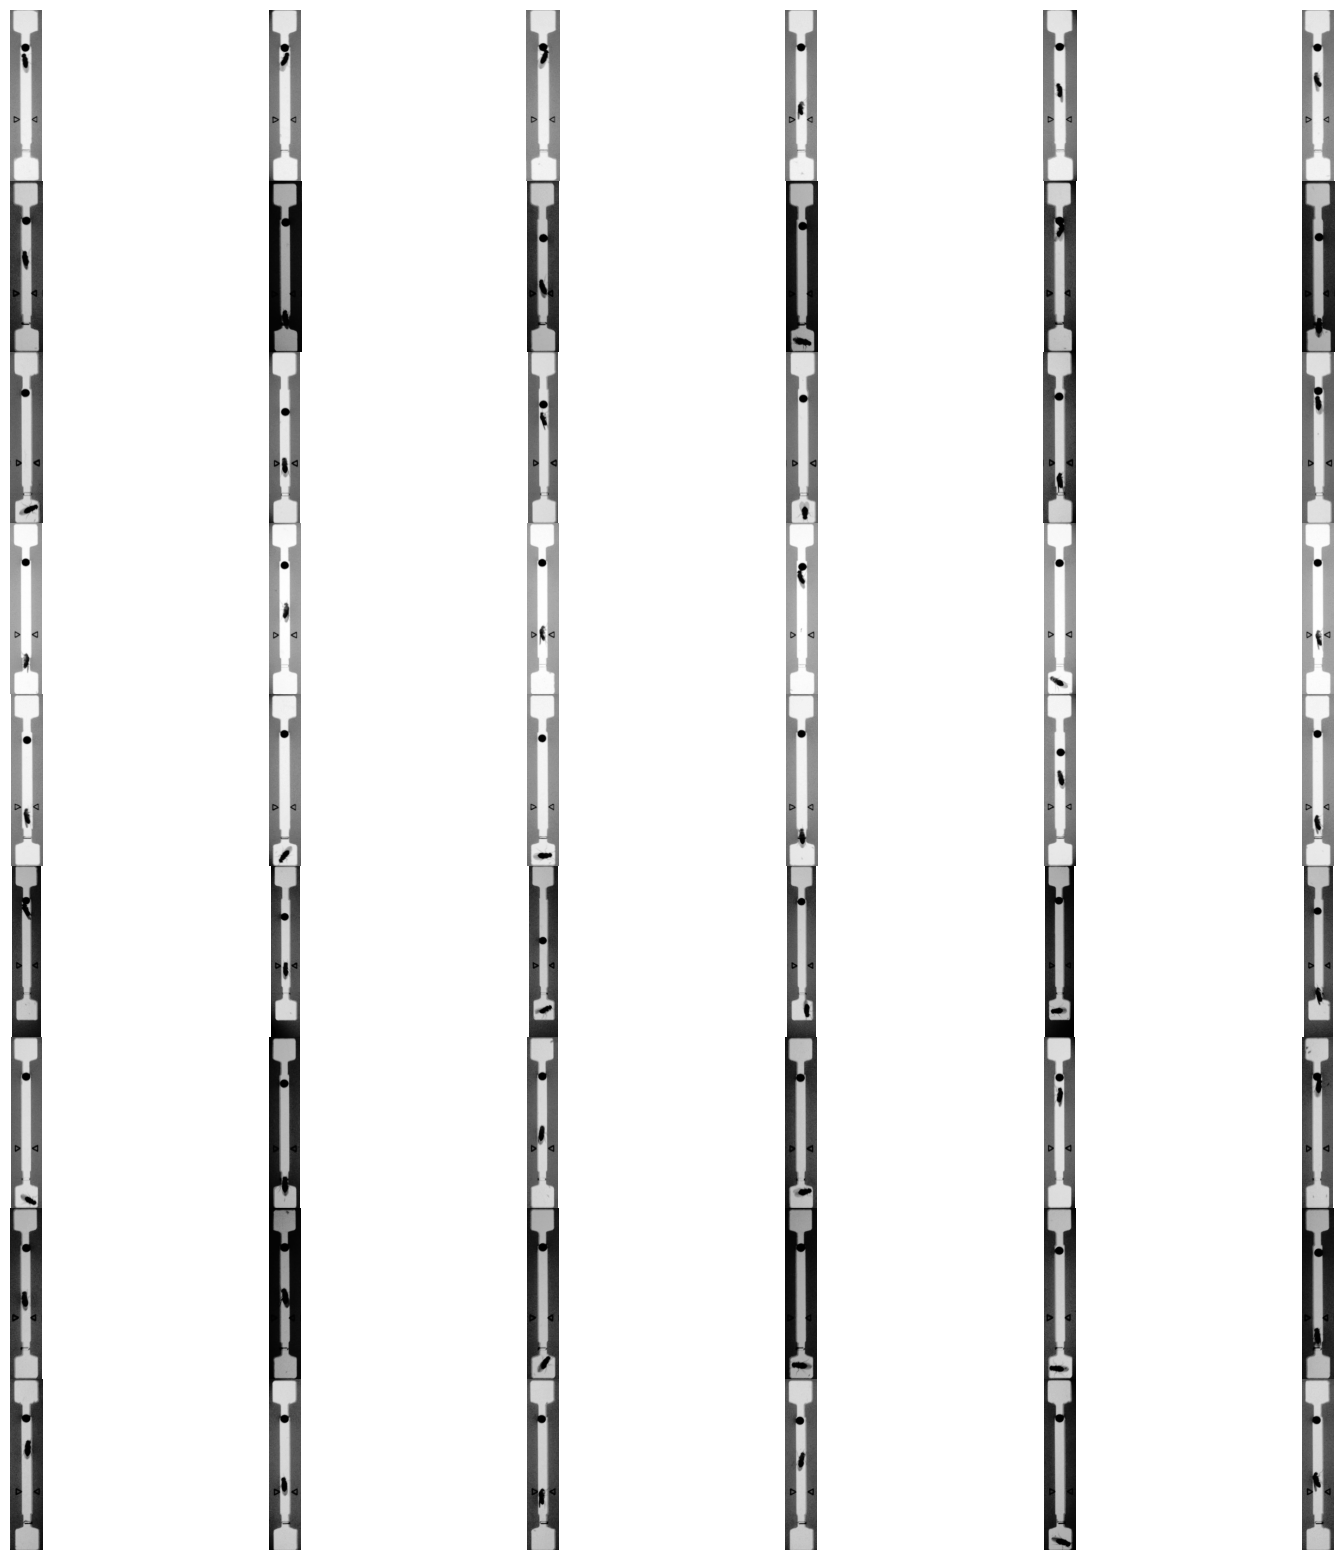

In [28]:
# Compute the global histogram and CDF
global_hist = compute_global_histogram(frames)
global_cdf = compute_global_cdf(global_hist)

# Apply global histogram equalization to each frame
equalized_frames = [
    apply_global_histogram_equalization(frame, global_cdf) for frame in frames
]

# Plot the equalized grid
plot_grid(equalized_frames, paths)

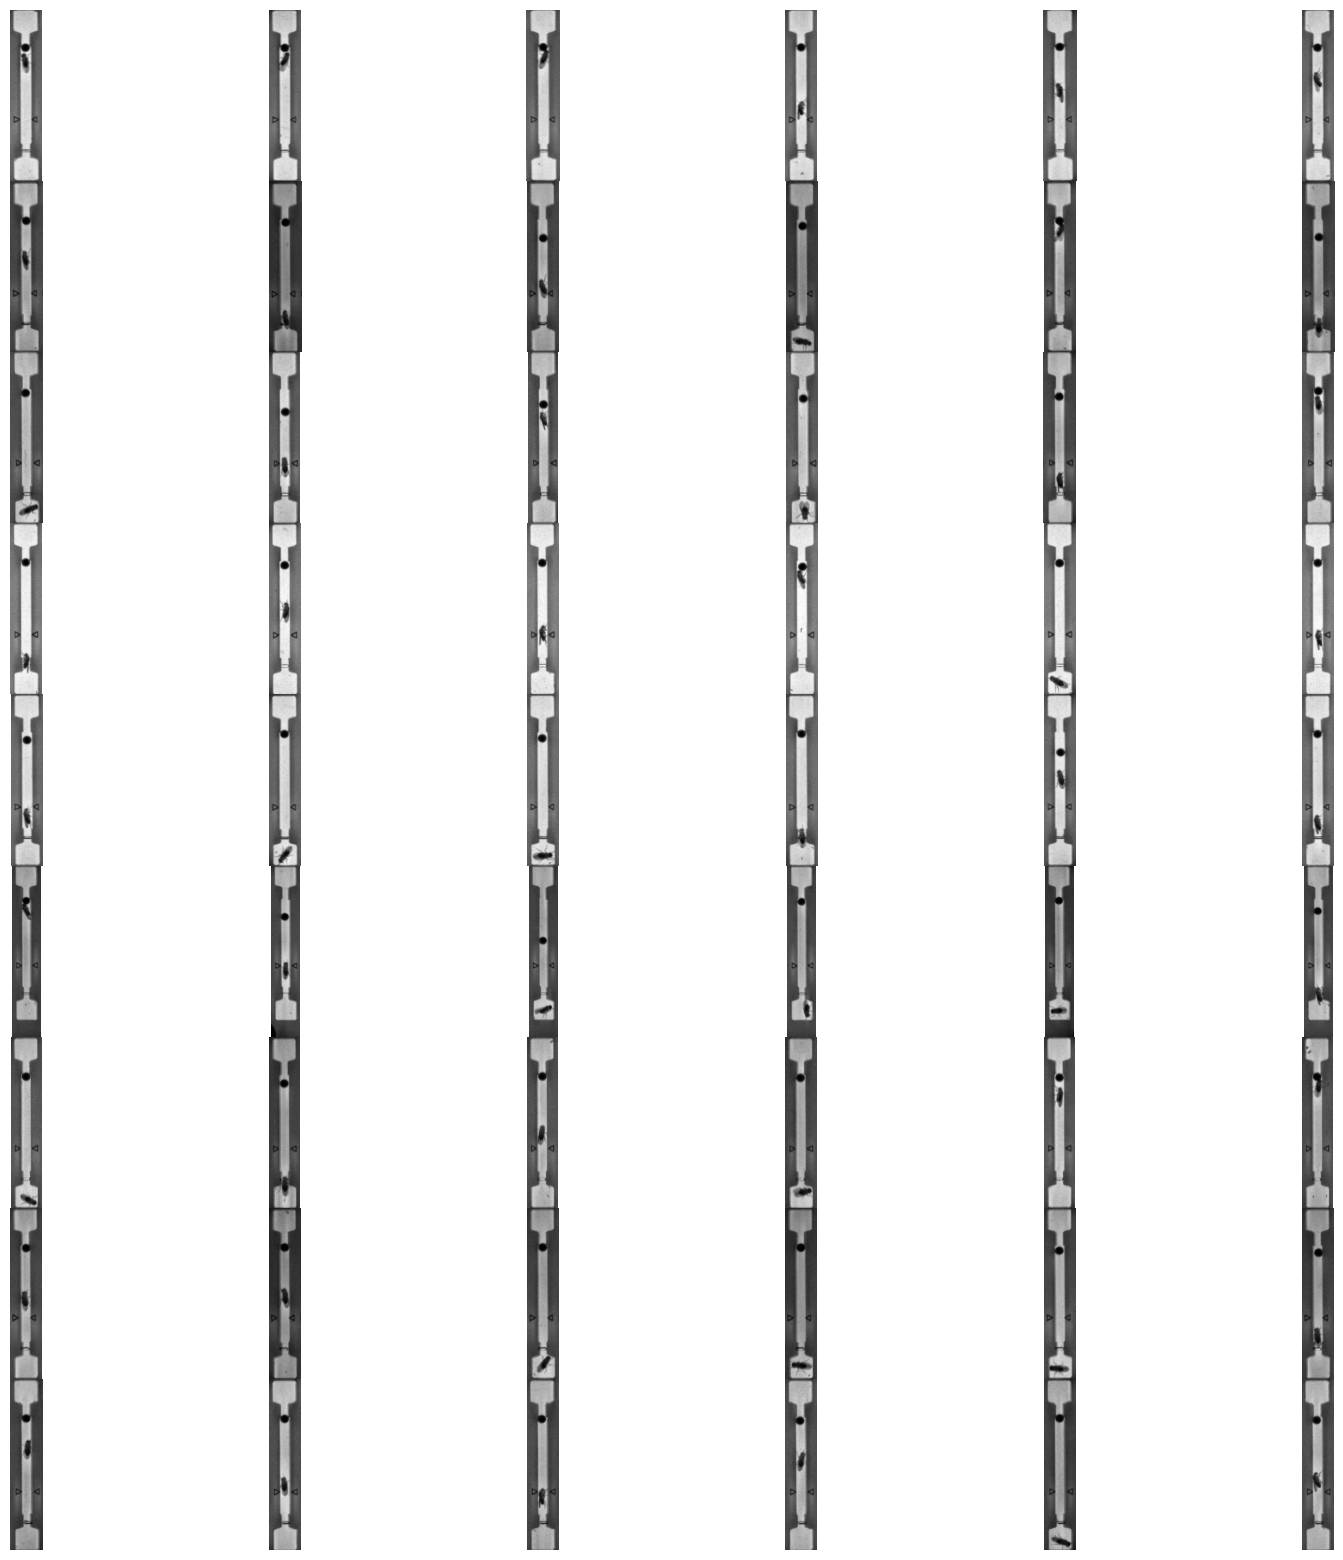

In [29]:
# Let's try instead to apply local histogram equalization to each frame

def apply_local_histogram_equalization(frame):
    """Apply local histogram equalization to a single frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_frame = clahe.apply(frame)
    return equalized_frame

# Apply local histogram equalization to each frame
equalized_frames = [apply_local_histogram_equalization(frame) for frame in frames]

# Plot the equalized grid
plot_grid(equalized_frames, paths)

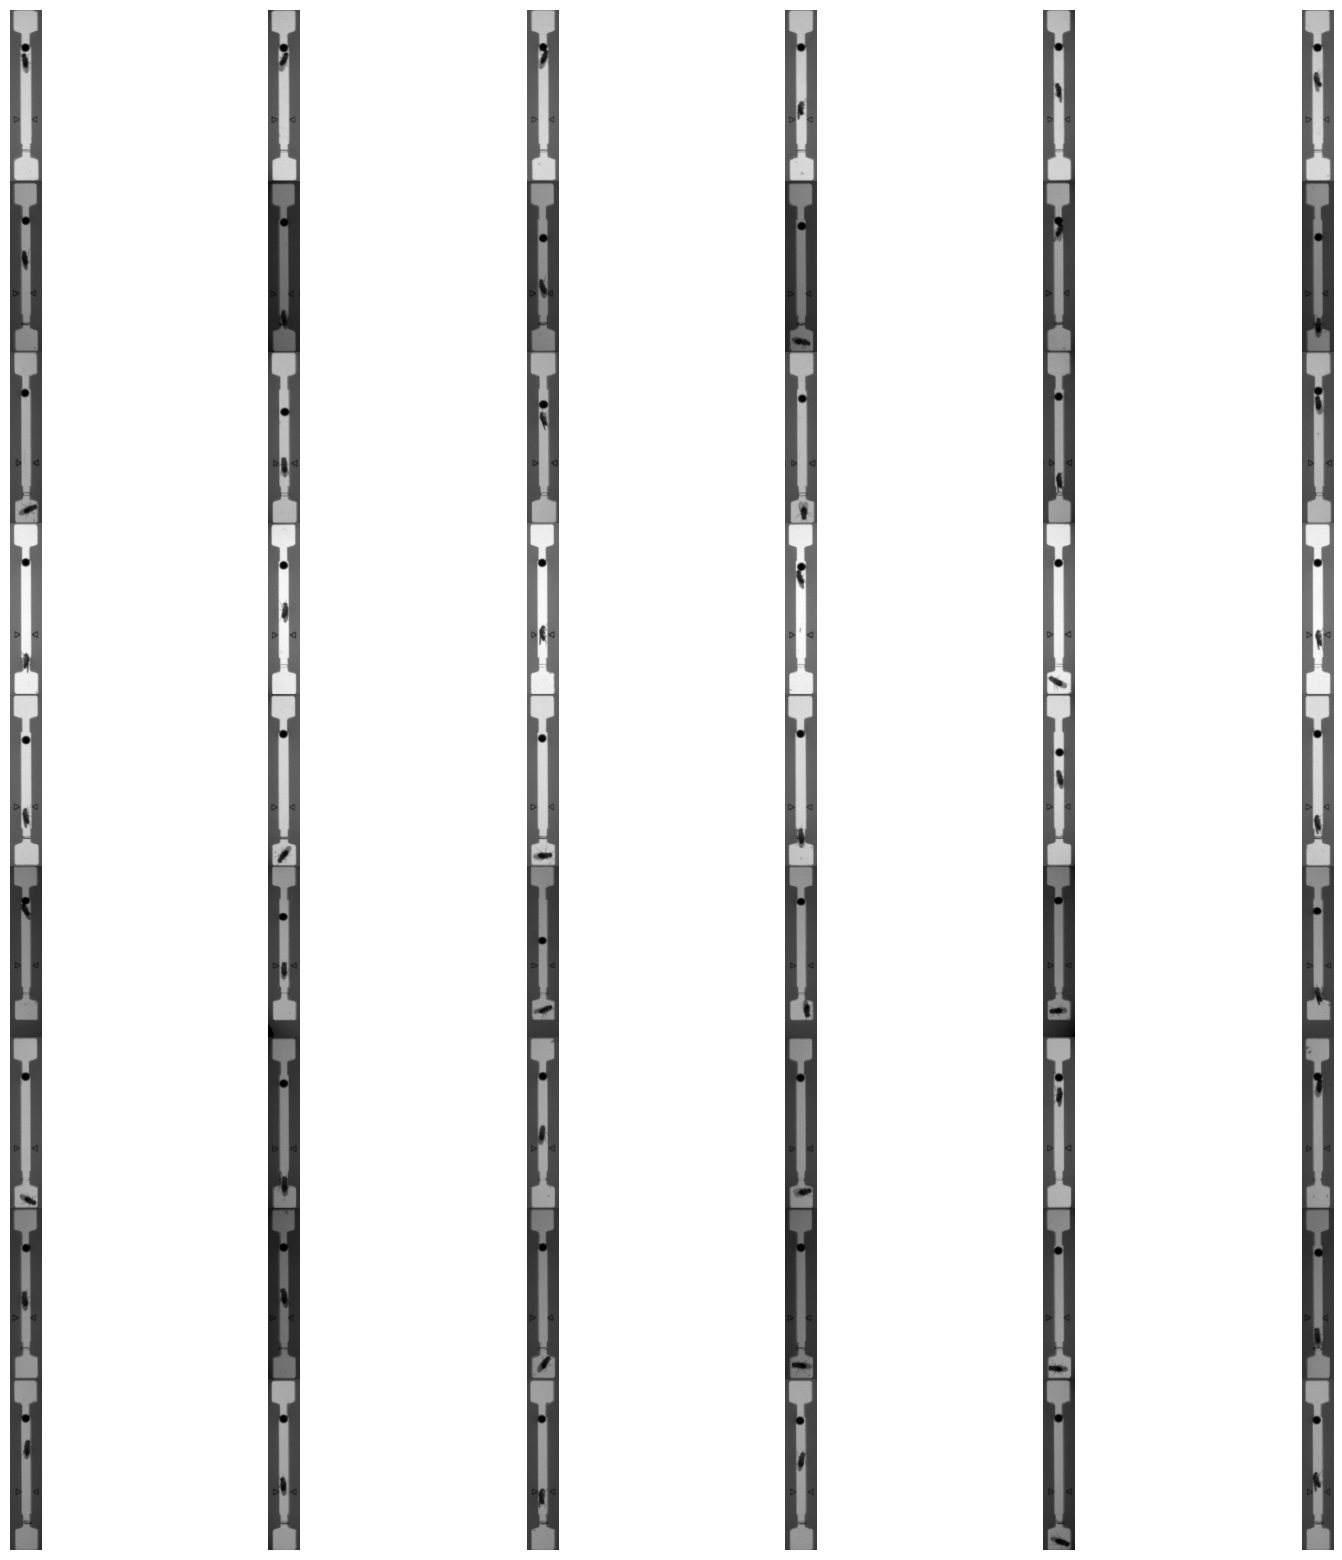

In [10]:
# Get the average size of the frames
heights = [frame.shape[0] for frame in frames]
widths = [frame.shape[1] for frame in frames]

avg_height = int(np.mean(heights))
avg_width = int(np.mean(widths))

# Resize all frames to the average size

def resize_frame(frame, avg_height, avg_width):
    
    resized_frame = cv2.resize(frame, (avg_width, avg_height))
    return resized_frame

# Resize all frames to the average size
resized_frames = [resize_frame(frame, avg_height, avg_width) for frame in frames]

# Plot the resized grid
plot_grid(resized_frames, paths)

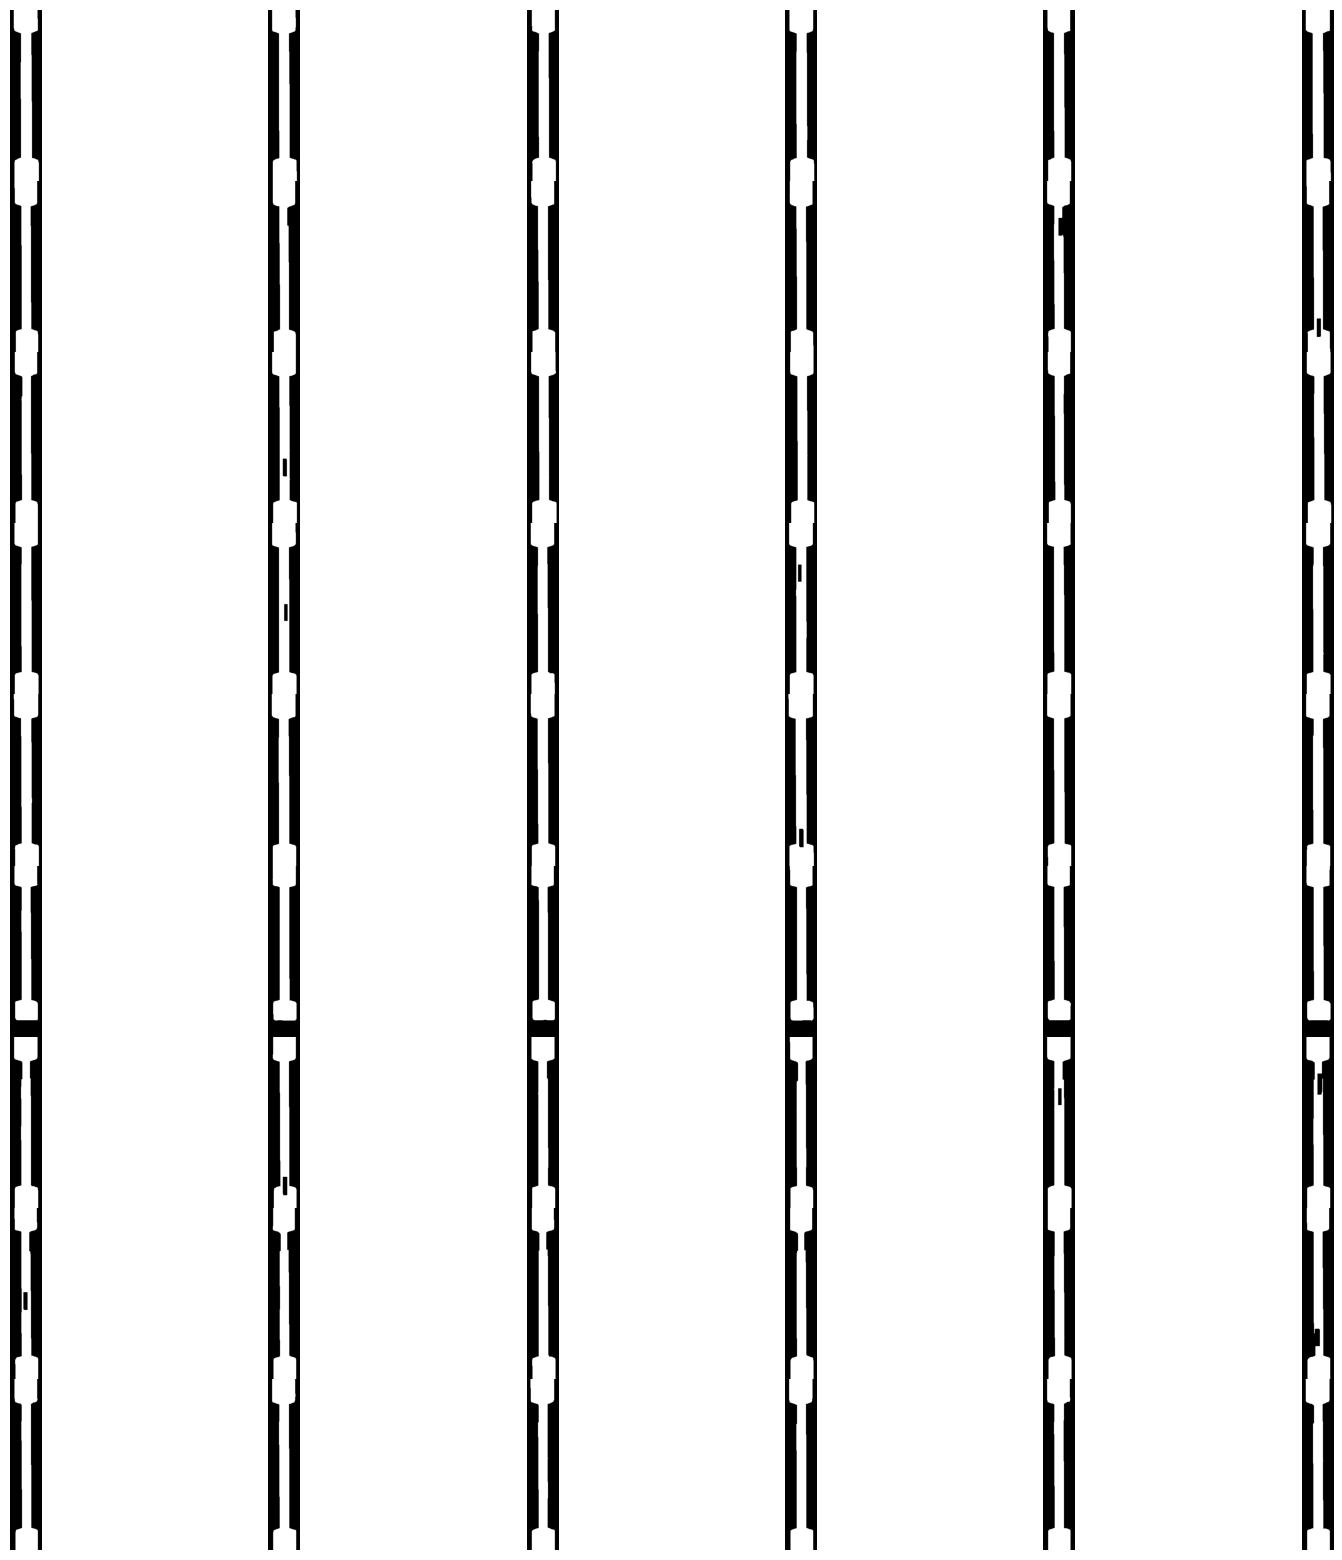

In [11]:
# Now we add a mask to the frames by detecting the corridors and masking the rest

def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    # binary = cv2.erode(binary, kernel, iterations=2)
    # binary = cv2.dilate(binary, kernel, iterations=3)

    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing

# Detect the corridors in each frame

binary_frames = [binarise(frame) for frame in resized_frames]

# Plot the corridor masks

plot_grid(binary_frames, paths)

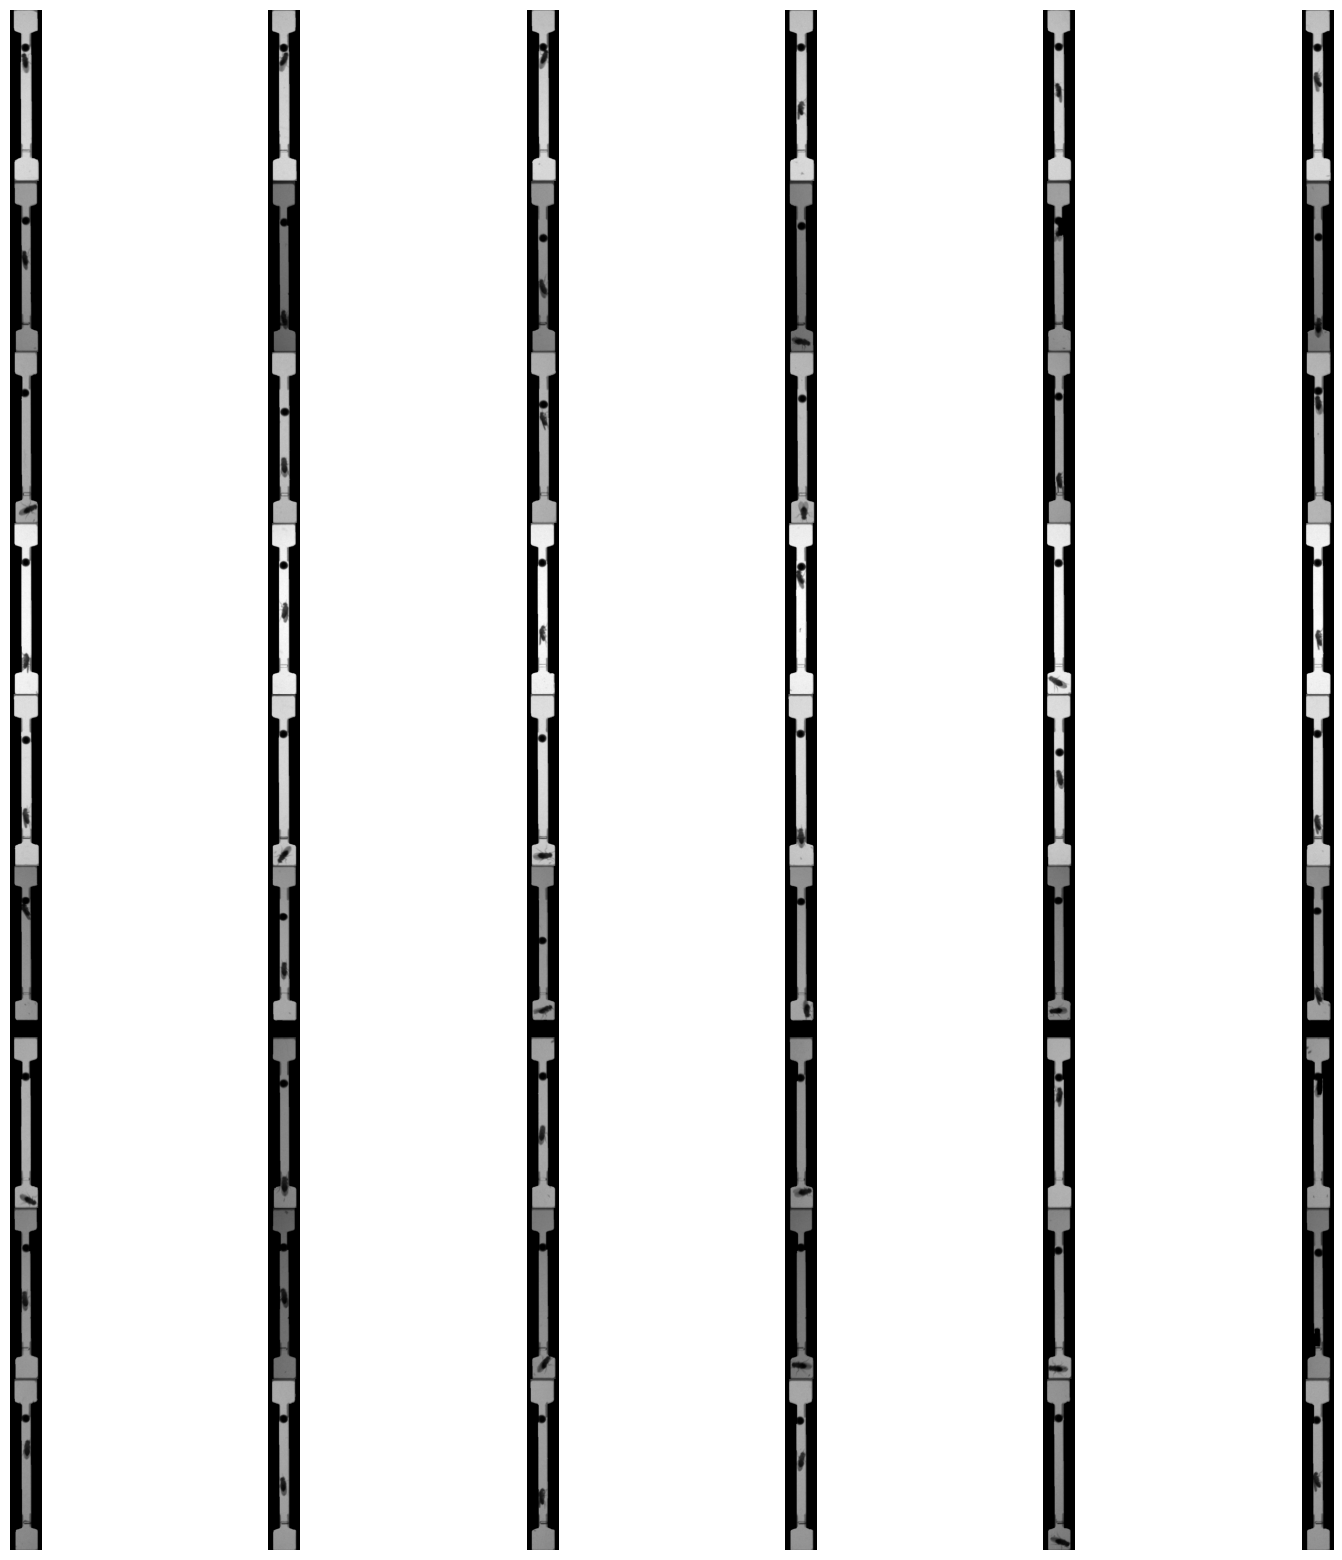

In [12]:
import cv2
import numpy as np


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # kernel = np.ones((10,10),np.uint8)
    # closing = cv2.erode(binary, kernel, iterations=2)
    # closing = cv2.dilate(binary, kernel, iterations=2)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask):
    """Apply the arena mask to the frame."""
    return cv2.bitwise_and(frame, frame, mask=mask)


# Detect the corridors in each frame and create masks
binary_frames = [binarise(frame) for frame in resized_frames]
arena_masks = [create_arena_mask(binary_frame) for binary_frame in binary_frames]

# Apply the masks to the original frames
masked_frames = [
    apply_arena_mask(frame, mask) for frame, mask in zip(resized_frames, arena_masks)
]

# Plot the masked frames
plot_grid(masked_frames, paths)

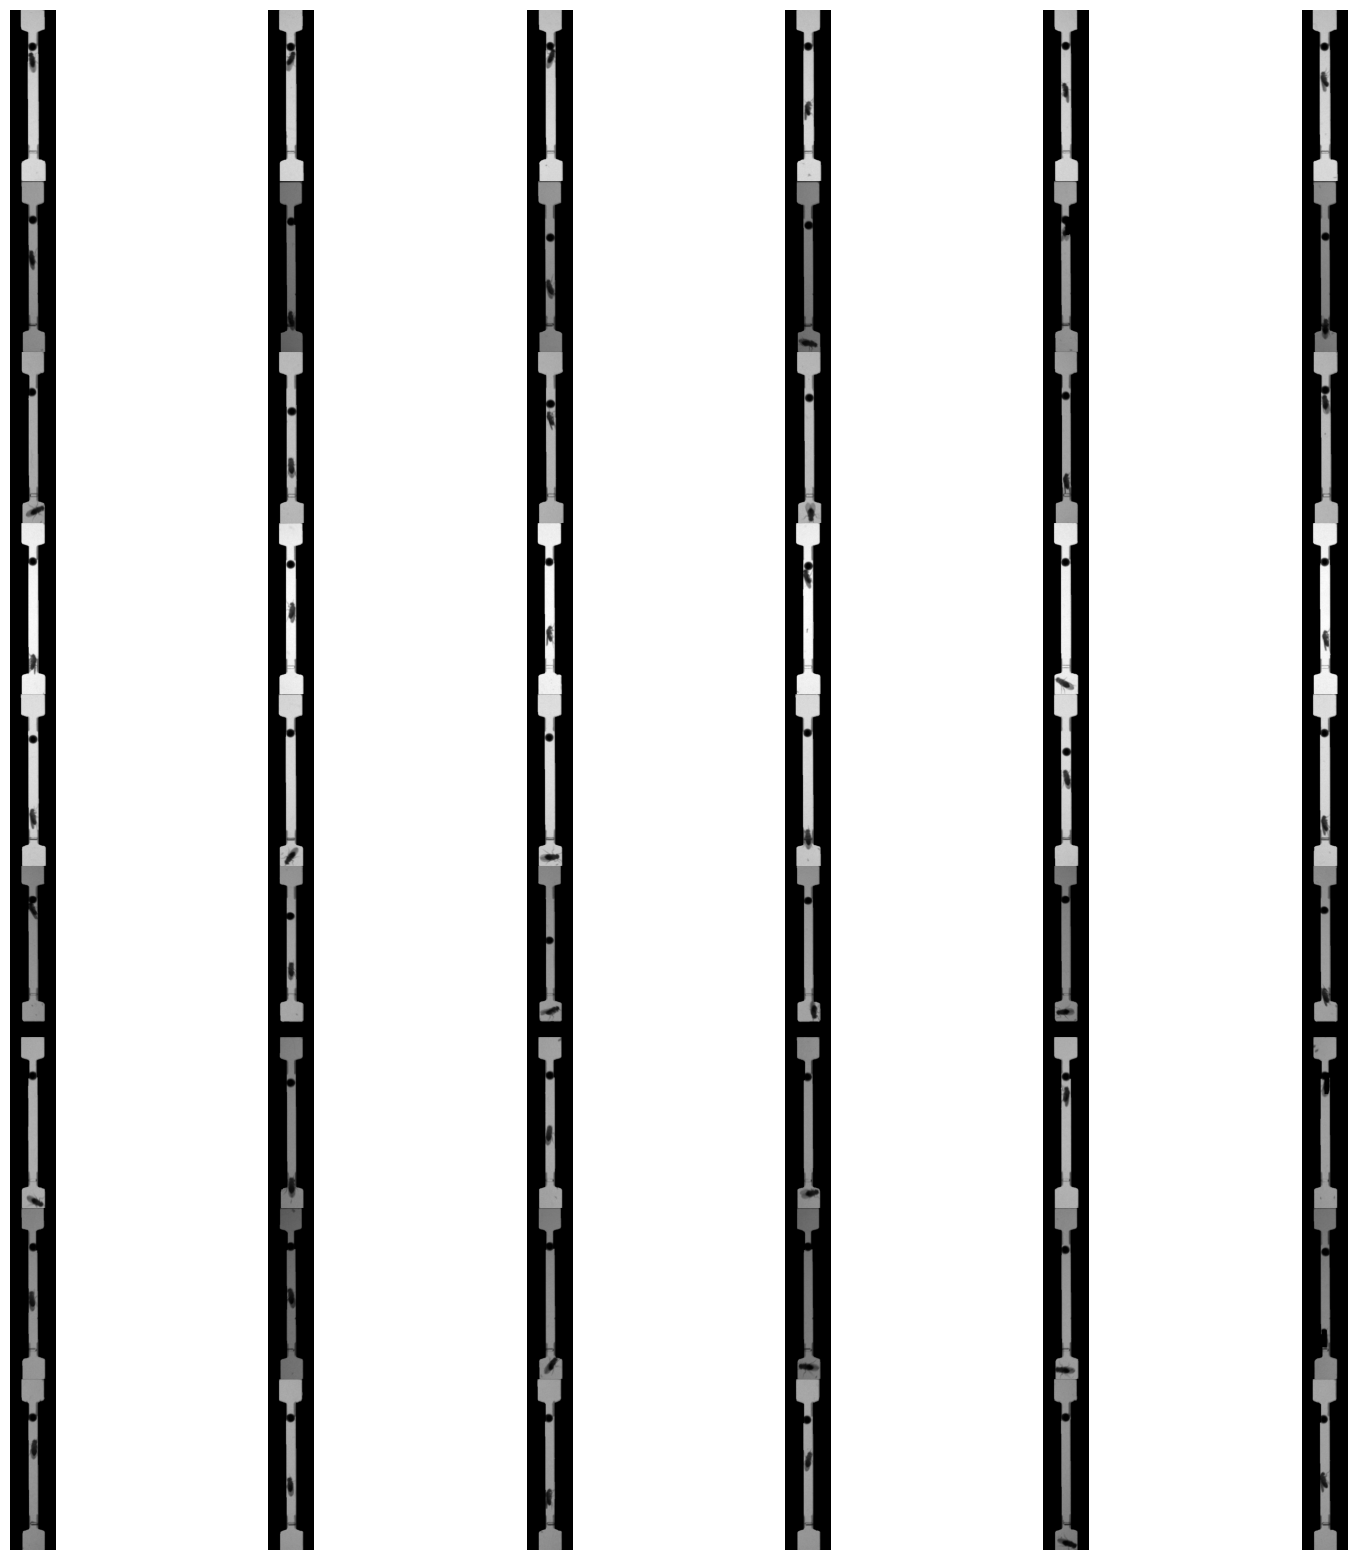

In [13]:
def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask):
    """Apply the arena mask to the frame and crop/pad the result."""
    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

    # Crop 10 pixels from top and bottom
    cropped_frame = masked_frame[5:-5, :]

    # Add 10 pixels of black padding to the left and right
    padded_frame = cv2.copyMakeBorder(
        cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_frame


# Detect the corridors in each frame and create masks
binary_frames = [binarise(frame) for frame in resized_frames]
arena_masks = [create_arena_mask(binary_frame) for binary_frame in binary_frames]

# Apply the masks to the original frames
masked_frames = [
    apply_arena_mask(frame, mask) for frame, mask in zip(resized_frames, arena_masks)
]

# Plot the masked frames
plot_grid(masked_frames, paths)

In [129]:
def equalize_histogram(frame, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to equalize the histogram of the frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    equalized_frame = clahe.apply(frame)
    return equalized_frame


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing

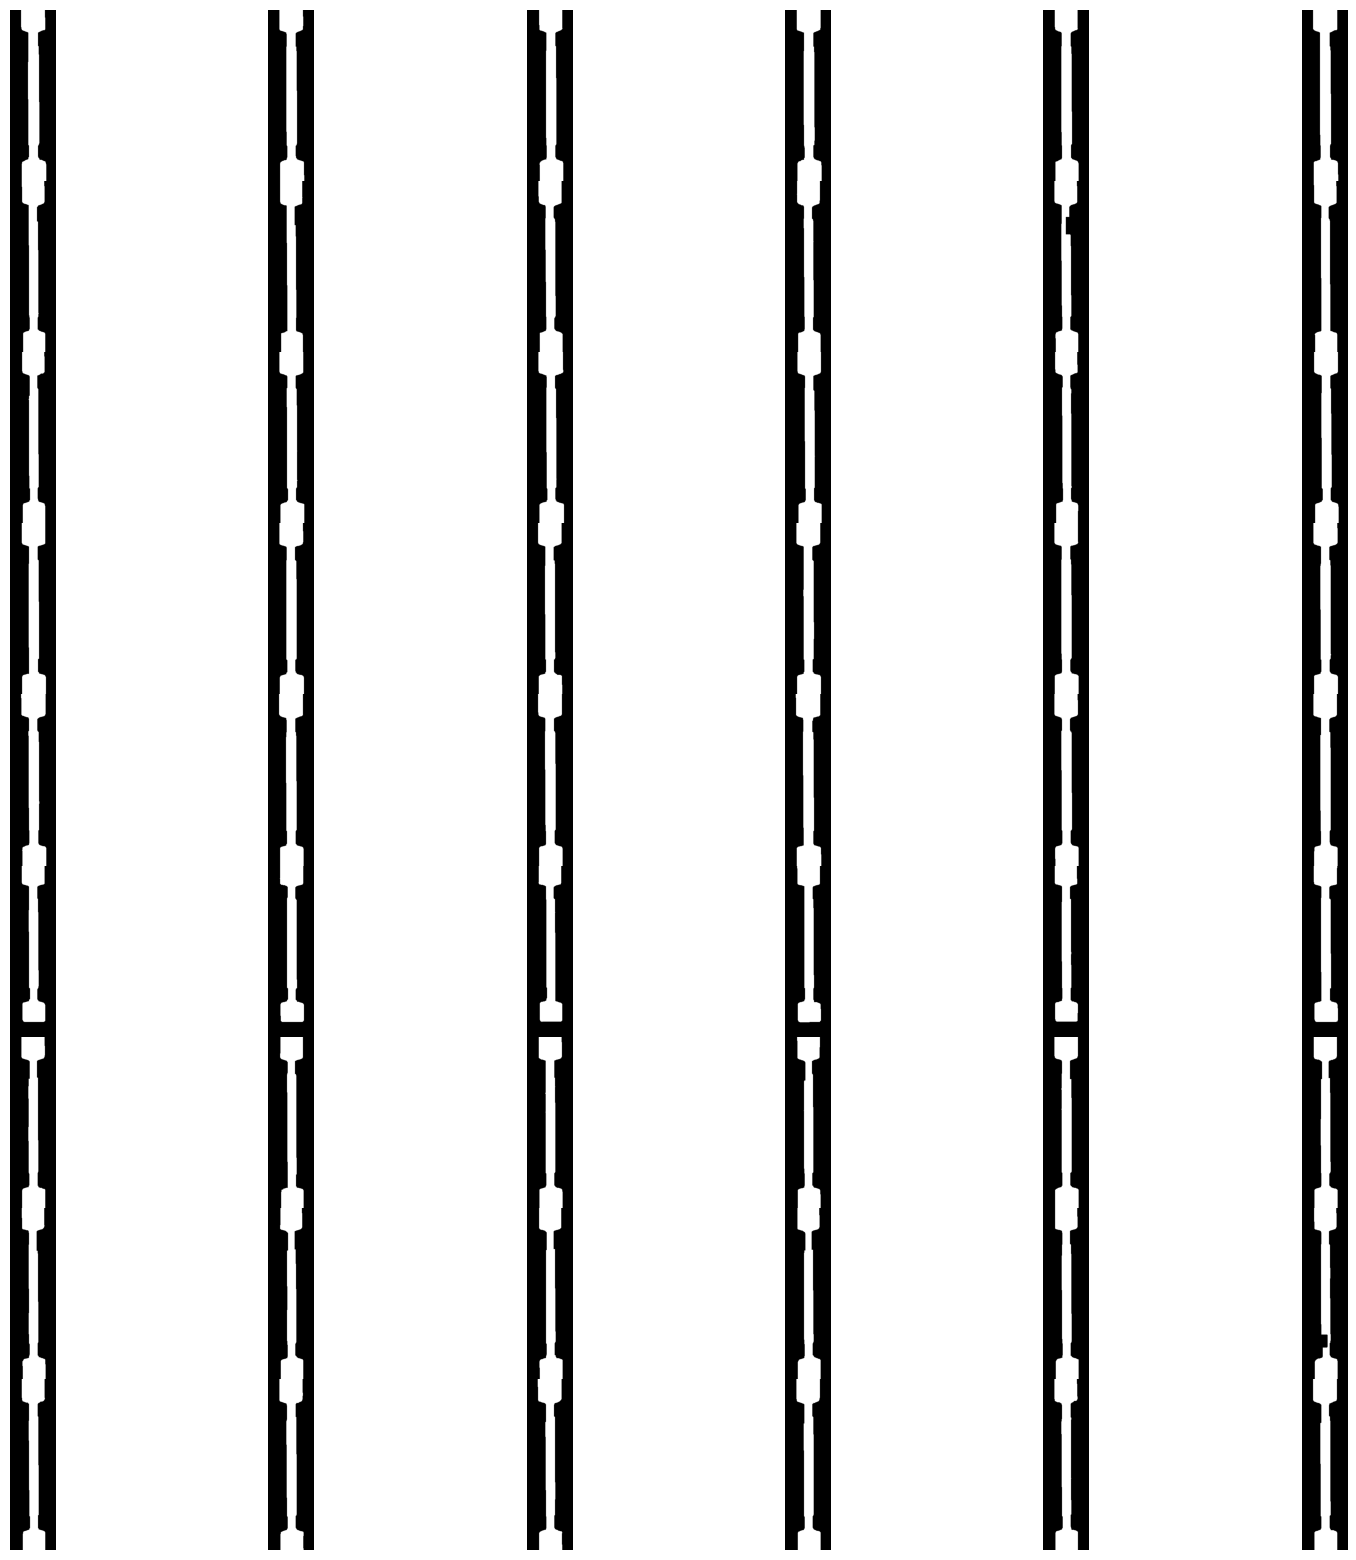

In [130]:
# Equalize the histogram of the masked frames and binarize them

equalized_frames = [equalize_histogram(frame) for frame in masked_frames]
binary_frames = [binarise(frame) for frame in equalized_frames]

# Plot the binary frames
plot_grid(binary_frames, paths)

# 1 step preprocessing

Here we regroup all relevant stuff for one given frame

Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters for frame: (1.0, (4, 4))
Best parameters 

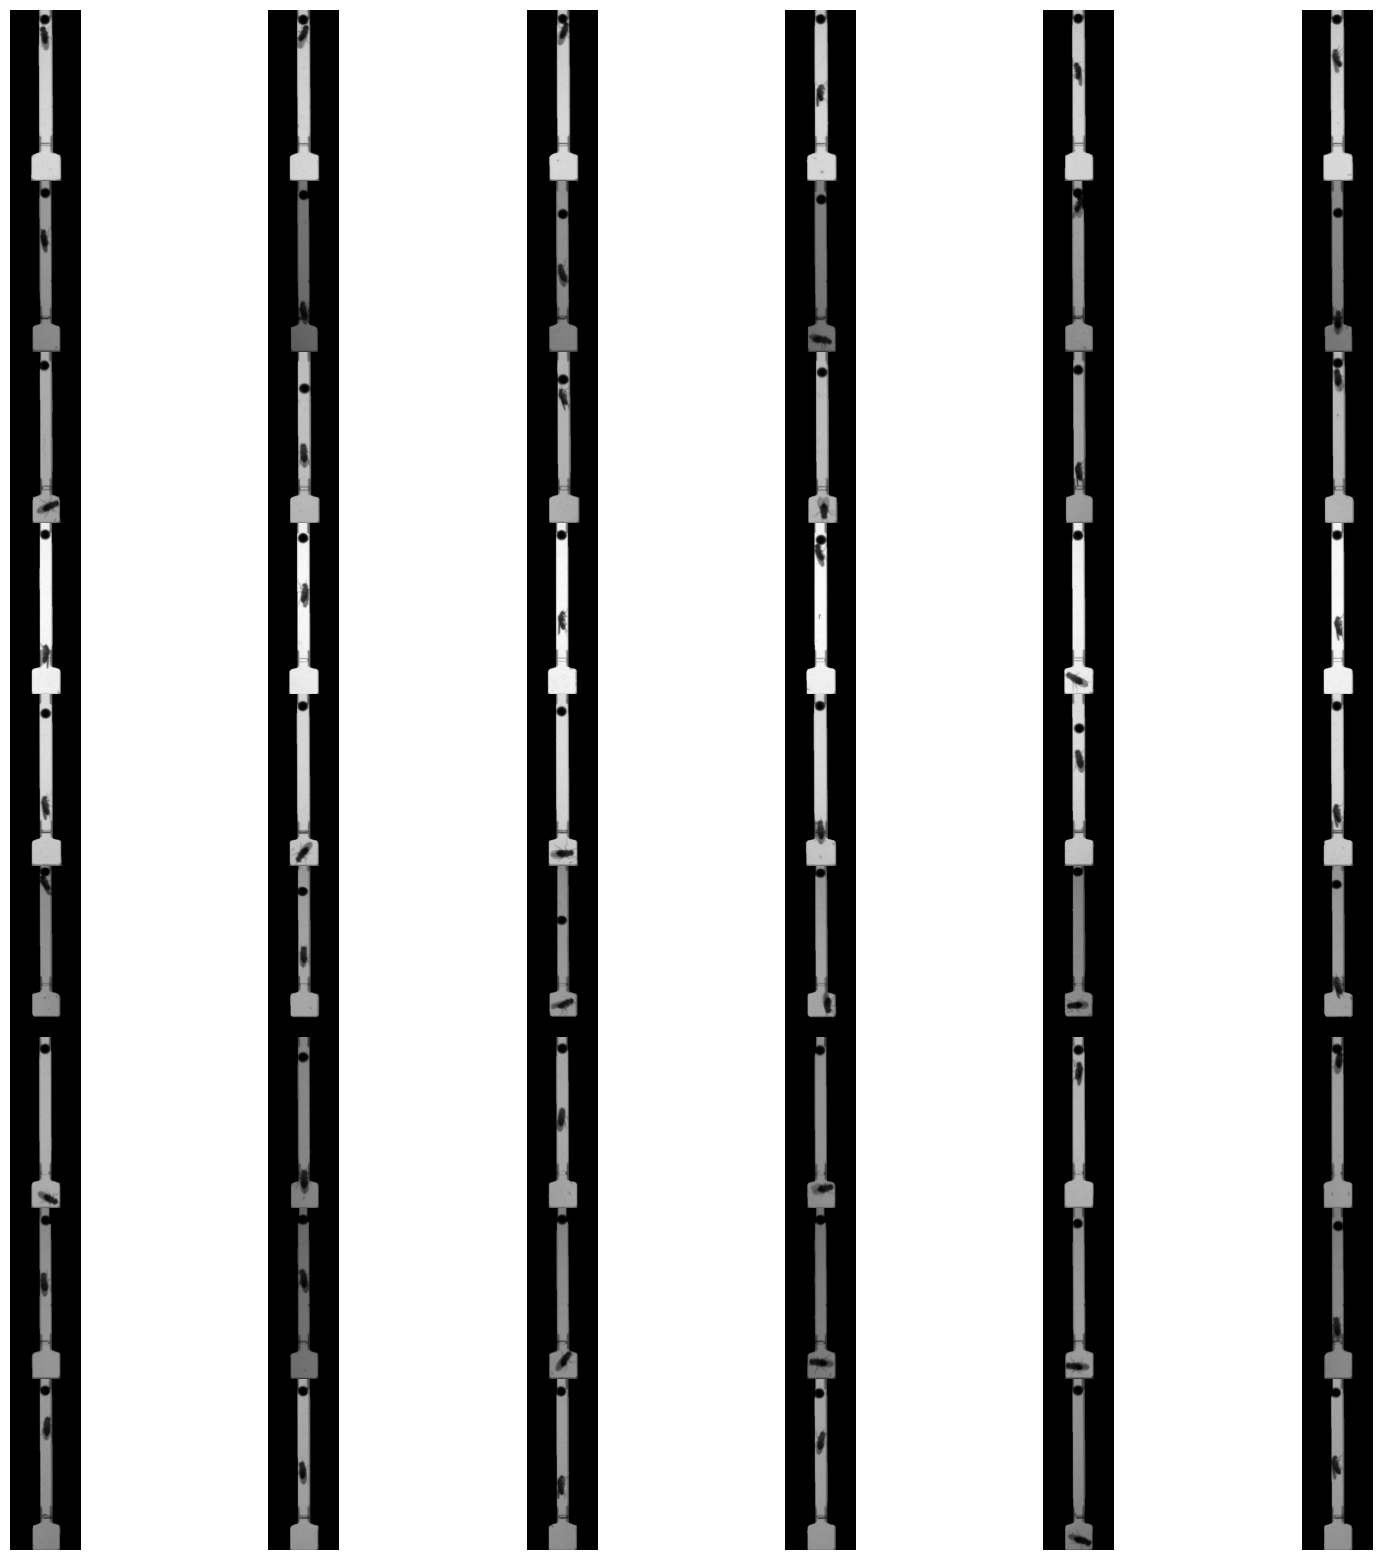

In [114]:
from scipy import ndimage

def resize_frame(frame, width, height):
    """Resize the frame to the given width and height."""
    return cv2.resize(frame, (width, height))


def equalize_histogram(frame, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to equalize the histogram of the frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    equalized_frame = clahe.apply(frame)
    return equalized_frame


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing


def remove_background(frame):
    """Remove the background using more advanced methods."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)
    fg_mask = bg_subtractor.apply(frame)

    # Remove noise from the mask
    kernel = np.ones((5, 5), np.uint8)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

    return fg_mask


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask, dilation_iterations=2, padding=True, cropping = True):
    """Apply the arena mask to the frame and crop/pad the result."""
    # Dilate the mask to make it slightly larger
    kernel = np.ones((5, 5), np.uint8)  # Adjust the kernel size as needed
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)

    # Apply the dilated mask to the frame
    masked_frame = cv2.bitwise_and(frame, frame, mask=dilated_mask)

    if cropping:
        # Crop 6 pixels from top and bottom
        cropped_frame = masked_frame[45:, :]

    if padding:
        # Add 20 pixels of black padding to the left and right
        padded_frame = cv2.copyMakeBorder(
            cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

    else:
        padded_frame = masked_frame

    return padded_frame


def gaussian_smooth(frame):
    """Apply a Gaussian blur to the frame."""

    smoothed = cv2.GaussianBlur(frame, (5, 5), 0)
    return smoothed


def scfilter(frame, iterations=1, kernel=5):
    """Sine-Cosine Filter with proper data type conversion"""
    # Ensure the frame is in float32 for compatibility
    frame = frame.astype(np.float32)

    for _ in range(iterations):
        frame = np.arctan2(
            ndimage.uniform_filter(np.sin(frame), size=kernel),
            ndimage.uniform_filter(np.cos(frame), size=kernel),
        )

    # Convert back to uint8
    frame = (frame / (2 * np.pi) * 255).astype(np.uint8)

    return frame


def median_filter(frame, kernel_size=5):
    return cv2.medianBlur(frame, kernel_size)


def bilateral_filter(frame, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(frame, d, sigmaColor, sigmaSpace)


def preprocess_frame(
    frame,
    width,
    height,
    clip_limit,
    tile_grid_size,
    dilation_iterations=2,
    padding=True,
    smoothing=True,
    background_subtraction=True,
):
    """Preprocess the frame by resizing, applying CLAHE, binarizing, and applying mask."""
    resized_frame = resize_frame(frame, width, height)

    if background_subtraction:
        frame_no_background = remove_background(resized_frame)
    else:
        frame_no_background = resized_frame

    binary_frame = binarise(frame_no_background)
    arena_mask = create_arena_mask(binary_frame)
    masked_frame = apply_arena_mask(
        resized_frame,
        arena_mask,
        dilation_iterations=dilation_iterations,
        padding=padding,
    )

    equalized_frame = equalize_histogram(masked_frame, clip_limit, tile_grid_size)
    # median_filtered = median_filter(equalized_frame)

    bilateral_filtered = bilateral_filter(equalized_frame)

    if smoothing:
        final_frame = gaussian_smooth(bilateral_filtered)
    else:
        final_frame = masked_frame

    return final_frame


def evaluate_contrast(frame):
    """Evaluate the contrast of a frame."""
    return frame.std()


# Template size
template_width = 96
template_height = 516

# Define parameter ranges
clip_limits = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
tile_grid_sizes = [(4, 4), (6, 6), (8, 8), (10, 10), (16, 16), (20, 20), (32, 32)]

best_params_per_frame = []

# Grid search for each frame
for frame in frames:
    best_params = None
    best_contrast = -np.inf

    for clip_limit in clip_limits:
        for tile_grid_size in tile_grid_sizes:
            processed_frame = preprocess_frame(
                frame, template_width, template_height, clip_limit, tile_grid_size, dilation_iterations=0, padding=False, smoothing=False
            )
            contrast = evaluate_contrast(processed_frame)

            # Save the best parameters
            if contrast > best_contrast:
                best_contrast = contrast
                best_params = (clip_limit, tile_grid_size)

    print(f"Best parameters for frame: {best_params}")

    best_params_per_frame.append(best_params)

# Preprocess each frame with its best parameters and apply dilation
preprocessed_frames = []
for frame, best_params in zip(frames, best_params_per_frame):
    processed_frame = preprocess_frame(
        frame, template_width, template_height, best_params[0], best_params[1], dilation_iterations=0, padding=True, smoothing=False
    )
    binary_frame = binarise(processed_frame)
    arena_mask = create_arena_mask(binary_frame)
    final_frame = apply_arena_mask(
        processed_frame, arena_mask, dilation_iterations=0, padding=True
    )  # Apply dilation here
    preprocessed_frames.append(final_frame)

# Plot the preprocessed frames
plot_grid(preprocessed_frames, paths)

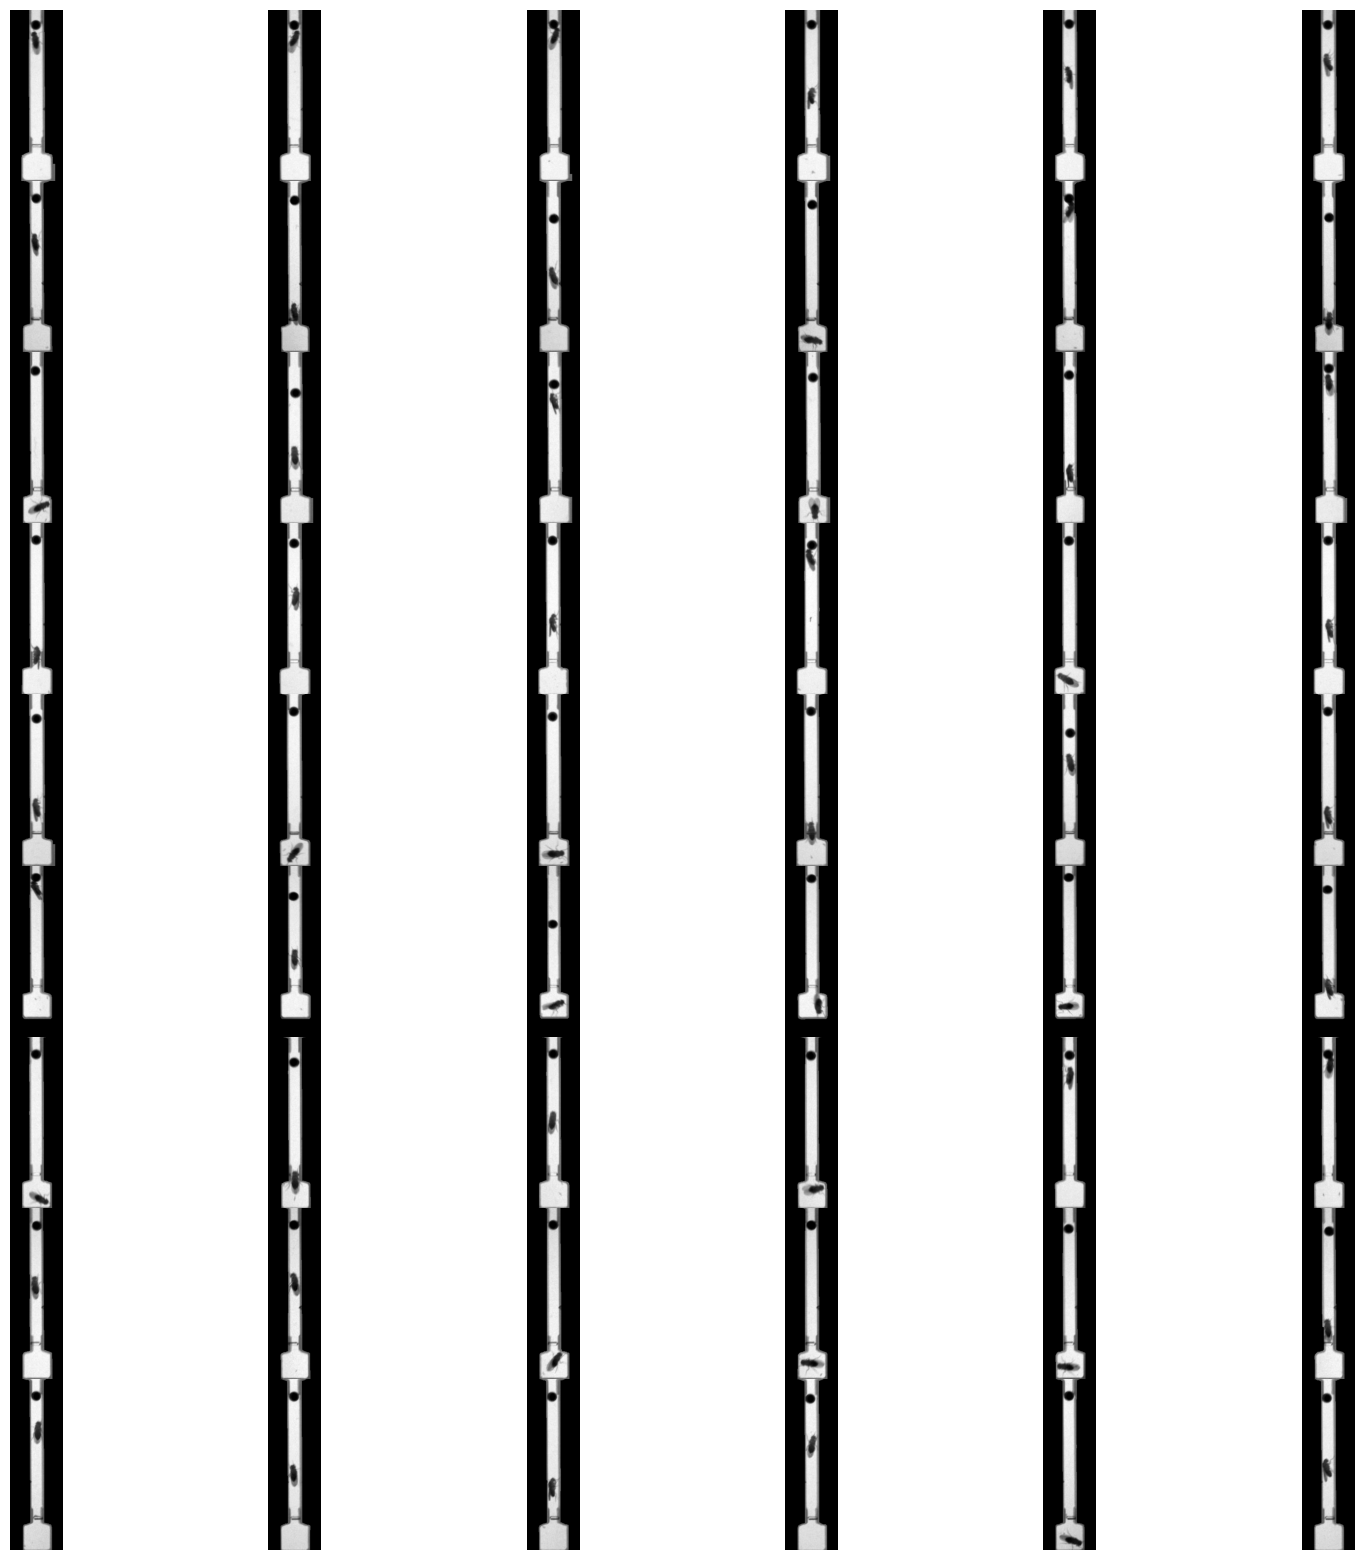

In [164]:
def resize_frame(frame, width, height):
    """Resize the frame to the given width and height."""
    return cv2.resize(frame, (width, height))


def histogram_stretching(frame):
    """Enhance contrast using histogram stretching."""
    min_val, max_val = np.min(frame), np.max(frame)
    return np.clip((frame - min_val) / (max_val - min_val) * 255, 0, 255).astype(
        np.uint8
    )


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Adjust the kernel size and morphology to better preserve edges
    kernel = np.ones((60, 20), np.uint8)  # Use a smaller kernel to avoid losing details
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask and find the largest contour
    mask = np.zeros_like(binary_frame)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask, dilation_iterations=1, padding=True, cropping=True):
    """Apply the arena mask to the frame and optionally crop/pad the result."""
    # Dilate the mask slightly to ensure edges are included
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)

    # Apply the dilated mask to the frame
    masked_frame = cv2.bitwise_and(frame, frame, mask=dilated_mask)

    if cropping:
        # Adjust crop size if needed
        cropped_frame = masked_frame[75:, :]  # Crop a bit less to preserve edges
    else:
        cropped_frame = masked_frame

    if padding:
        # Add black padding to the left and right
        padded_frame = cv2.copyMakeBorder(
            cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
    else:
        padded_frame = cropped_frame

    return padded_frame


def preprocess_frame(
    frame, width, height, dilation_iterations=1, padding=True, smoothing=False
):
    """Preprocess the frame by resizing, stretching histograms, binarizing, masking, and enhancing contrast."""
    resized_frame = resize_frame(frame, width, height)

    # First histogram stretching before binarization
    stretched_frame = histogram_stretching(resized_frame)

    # Binarize and create mask
    binary_frame = binarise(stretched_frame)
    
    arena_mask = create_arena_mask(binary_frame)

    # Apply mask with optional dilation
    masked_frame = apply_arena_mask(
        resized_frame, arena_mask, dilation_iterations, padding
    )

    # Second histogram stretching after masking
    final_frame = histogram_stretching(masked_frame)

    # Optionally smooth the frame
    if smoothing:
        final_frame = cv2.GaussianBlur(final_frame, (5, 5), 0)

    return final_frame


# Preprocess frames
preprocessed_frames = [
    preprocess_frame(
        frame,
        width=template_width,
        height=template_height,
        dilation_iterations=2,
        padding=True,
        smoothing=False,
    )
    for frame in frames
]


# Plot the frames classic

plot_grid(preprocessed_frames, paths)

In [ ]:
# Plot one of the preporcesse frames with bigger size, side by side with the original frame

def plot_preprocessed_frame(original_frame, preprocessed_frame):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].imshow(original_frame, cmap="gray", vmin=0, vmax=255)
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    axs[1].imshow(preprocessed_frame, cmap="gray", vmin=0, vmax=255)
    axs[1].set_title("Preprocessed Frame")
    axs[1].axis("off")

    plt.show()

# Plot the first preprocessed frame

for frame in range(len(preprocessed_frames)):

    plot_preprocessed_frame(frames[frame], preprocessed_frames[frame])

# Translate annotated labels

In [168]:
import random


def resize_labels(labels, original_width, original_height, new_width, new_height):
    """Resize the labels according to the new frame size."""
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    return [(int(x * x_scale), int(y * y_scale)) for x, y in labels]


def apply_arena_mask_to_labels(labels, mask_padding, crop_top, crop_bottom, new_height):
    """Adjust the labels according to the cropping and padding applied to the frame."""
    # Crop from top and bottom
    cropped_labels = [
        (x, y - crop_top)
        for x, y in labels
        if crop_top <= y < (new_height - crop_bottom)
    ]

    # Add padding to the left and right
    padded_labels = [(x + mask_padding, y) for x, y in cropped_labels]

    return padded_labels


def preprocess_labels(
    labels,
    original_width,
    original_height,
    template_width,
    template_height,
    mask_padding=20,
    crop_top=74,
    crop_bottom=0,
):
    """Preprocess the labels by resizing and applying mask transformations."""
    # Resize the labels according to the new frame size
    resized_labels = resize_labels(
        labels, original_width, original_height, template_width, template_height
    )

    # Apply arena mask transformations
    final_labels = apply_arena_mask_to_labels(
        resized_labels, mask_padding, crop_top, crop_bottom, template_height
    )

    return final_labels


def generate_random_labels(frame, num_labels=10):
    """Generate random labels within the bounds of the frame."""
    height, width = frame.shape[:2]
    return [
        (random.randint(0, width - 1), random.randint(0, height - 1))
        for _ in range(num_labels)
    ]


def plot_frames_with_labels(frames, labels_list, title):
    """Plot frames with their corresponding labels."""
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for ax, frame, labels in zip(axes, frames, labels_list):
        ax.imshow(frame, cmap="gray")
        for x, y in labels:
            ax.plot(x, y, "ro")
        ax.axis("off")
    fig.suptitle(title)
    plt.show()

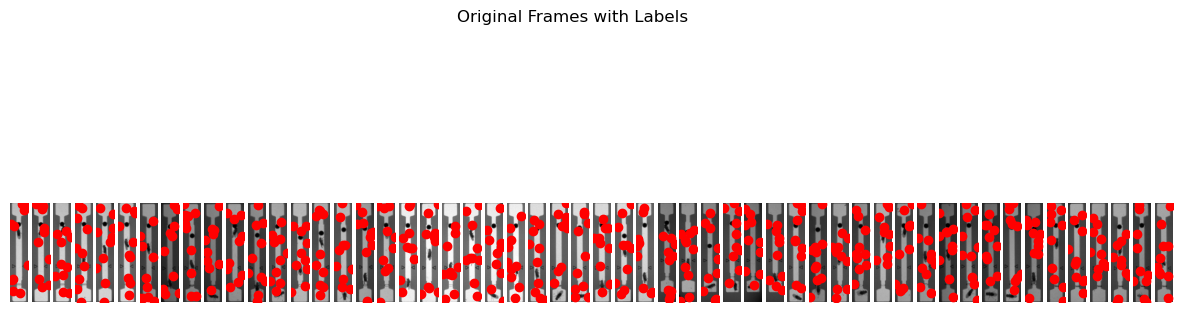

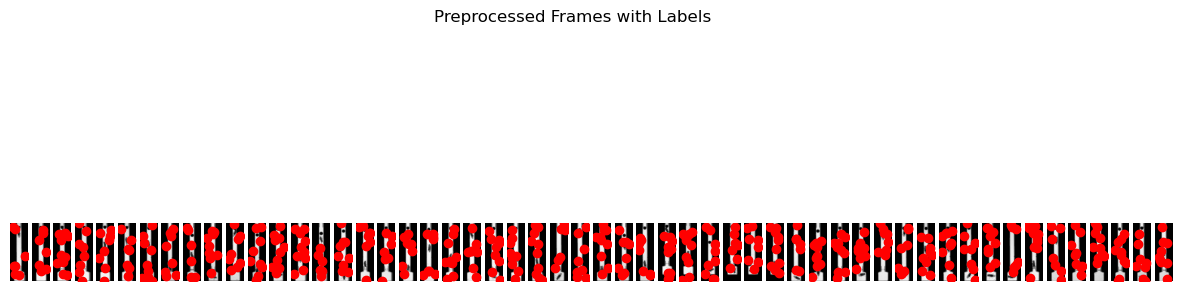

In [176]:
# Example usage with frames and random labels
# Template size
template_width = 96
template_height = 516

tracking_labels = [generate_random_labels(frame) for frame in resized_frames]

original_width, original_height = resized_frames[0].shape[1], resized_frames[0].shape[0]
preprocessed_labels = [
    preprocess_labels(
        labels,
        original_width,
        original_height,
        template_width,
        template_height,
        crop_top=74, crop_bottom=0,
    )
    for labels in tracking_labels
]

# Plot the original and preprocessed frames with labels
plot_frames_with_labels(resized_frames, tracking_labels, "Original Frames with Labels")
plot_frames_with_labels(
    preprocessed_frames, preprocessed_labels, "Preprocessed Frames with Labels"
)

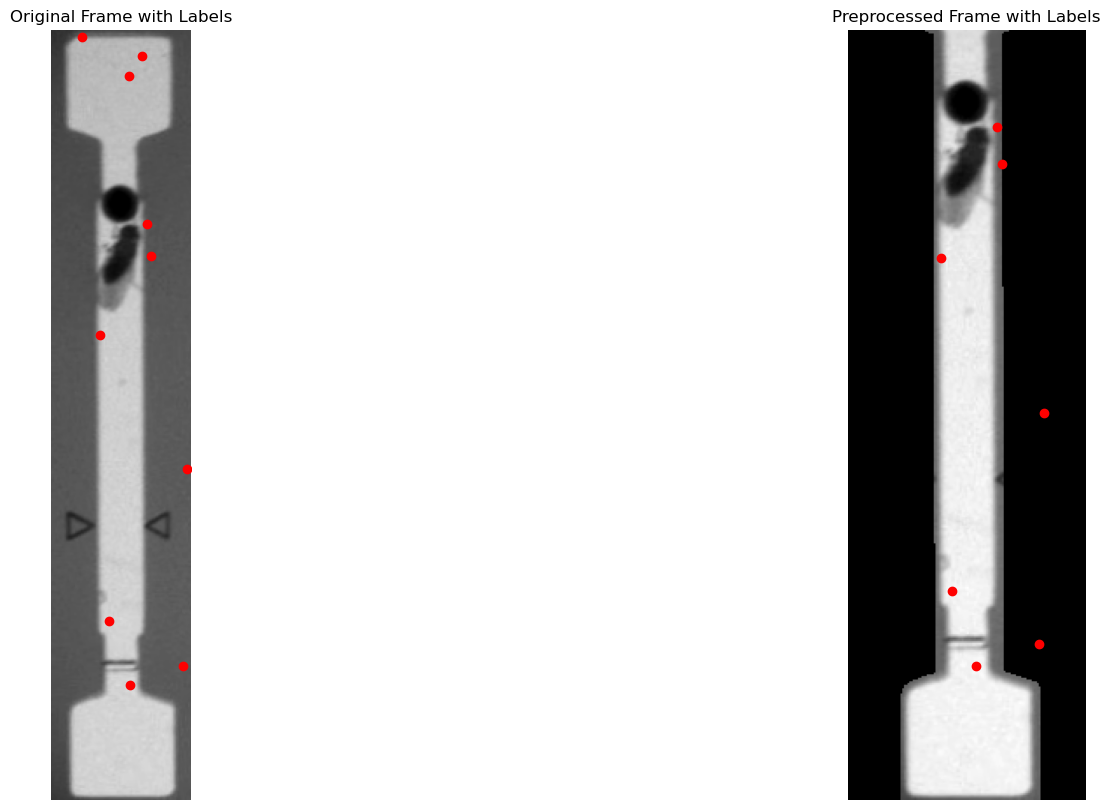

In [177]:
def display_frame_with_labels(
    original_frame, preprocessed_frame, original_labels, preprocessed_labels
):
    """Display a single frame with and without preprocessing along with their labels in a larger format."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Display original frame with labels
    axes[0].imshow(original_frame, cmap="gray")
    for x, y in original_labels:
        axes[0].plot(x, y, "ro")
    axes[0].set_title("Original Frame with Labels")
    axes[0].axis("off")

    # Display preprocessed frame with labels
    axes[1].imshow(preprocessed_frame, cmap="gray")
    for x, y in preprocessed_labels:
        axes[1].plot(x, y, "ro")
    axes[1].set_title("Preprocessed Frame with Labels")
    axes[1].axis("off")

    plt.show()


# Example usage with the first frame and its labels

frame_id = 1

original_frame = resized_frames[frame_id]
preprocessed_frame = preprocessed_frames[frame_id]
original_labels = tracking_labels[frame_id]
preprocessed_labels = preprocessed_labels[frame_id]

display_frame_with_labels(
    original_frame, preprocessed_frame, original_labels, preprocessed_labels
)

In [4]:
import sleap
import cv2
from pathlib import Path

# Template size
template_width = 96
template_height = 516

# Load the existing SLEAP project
labels = sleap.Labels.load_file(
    "/mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/FullBody_labels_1.v001.slp"
)


# Define the preprocessing functions
def resize_labels(labels, original_width, original_height, new_width, new_height):
    """Resize the labels according to the new frame size."""
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    return [(int(x * x_scale), int(y * y_scale)) for x, y in labels]


def apply_arena_mask_to_labels(labels, mask_padding, crop_top, crop_bottom, new_height):
    """Adjust the labels according to the cropping and padding applied to the frame."""
    # Crop from top and bottom
    cropped_labels = [
        (x, y - crop_top)
        for x, y in labels
        if crop_top <= y < (new_height - crop_bottom)
    ]

    # Add padding to the left and right
    padded_labels = [(x + mask_padding, y) for x, y in cropped_labels]

    return padded_labels


def preprocess_labels(
    labels,
    original_width,
    original_height,
    template_width,
    template_height,
    mask_padding=20,
    crop_top=74,
    crop_bottom=0,
):
    """Preprocess the labels by resizing and applying mask transformations."""
    # Resize the labels according to the new frame size
    resized_labels = resize_labels(
        labels, original_width, original_height, template_width, template_height
    )

    # Apply arena mask transformations
    final_labels = apply_arena_mask_to_labels(
        resized_labels, mask_padding, crop_top, crop_bottom, template_height
    )

    return final_labels


# Directory containing the preprocessed videos
preprocessed_folder = Path(
    "/mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New"
)

# Map to store video filename and corresponding preprocessed path
video_map = {}

# Build the video mapping between original and preprocessed videos
for video in labels.videos:
    original_video_path = Path(video.backend.filename)

    print(f"preprocessed folder: {preprocessed_folder}")
    # The preprocessed video filename is the same as the original with "_preprocessed" appended before the extension
    preprocessed_video_path = (
        preprocessed_folder
        / original_video_path.parent.parent.name
        / original_video_path.parent.name
        / (original_video_path.stem + "_preprocessed" + original_video_path.suffix)
    )

    print(f"Looking for preprocessed video: {preprocessed_video_path}")

    if preprocessed_video_path.exists():
        video_map[original_video_path] = preprocessed_video_path
    else:
        print(f"Warning: Preprocessed video not found for {original_video_path}")

# List to store old videos and labels for removal
videos_to_remove = []

# Loop through each video in the original project
for original_video in labels.videos:
    original_video_path = Path(original_video.backend.filename)

    # Check if the corresponding preprocessed video exists
    if original_video_path in video_map:
        preprocessed_video_path = video_map[original_video_path]
        print(f"Processing video: {original_video_path} -> {preprocessed_video_path}")

        # Load the preprocessed video to get its dimensions
        cap = cv2.VideoCapture(preprocessed_video_path.as_posix())
        ret, frame = cap.read()
        preprocessed_height, preprocessed_width, _ = frame.shape
        cap.release()

        # Get the original video dimensions
        cap = cv2.VideoCapture(original_video_path.as_posix())
        ret, frame = cap.read()
        original_height, original_width, _ = frame.shape
        cap.release()

        # Add the preprocessed video to the labels project
        preprocessed_video = sleap.Video.from_filename(
            preprocessed_video_path.as_posix()
        )
        labels.videos.append(preprocessed_video)

        # Preprocess labels associated with this video
        frames = labels.get(original_video)
        preprocessed_labeled_frames = []

        for labeled_frame in frames:
            src_labels = [
                (p.x, p.y)
                for instance in labeled_frame.instances
                for p in instance.points
            ]

            # Preprocess the labels using the working function
            preprocessed_labels = preprocess_labels(
                src_labels,
                original_width=original_width,
                original_height=original_height,
                template_width=template_width,
                template_height=template_height,
                mask_padding=20,  # Adjust based on your preprocessing settings
                crop_top=74,  # Adjust based on your preprocessing settings
                crop_bottom=0,  # Adjust based on your preprocessing settings
            )

            # Create instances for the preprocessed labels
            new_instances = []
            for instance in labeled_frame.instances:
                for node, (x, y) in zip(instance.points, preprocessed_labels):
                    node.x, node.y = x, y
                new_instances.append(instance)

            # Create a new labeled frame with the preprocessed video and new instances
            new_labeled_frame = sleap.LabeledFrame(
                video=preprocessed_video,
                frame_idx=labeled_frame.frame_idx,
                instances=new_instances,
            )

            # Add the new labeled frame to the list
            preprocessed_labeled_frames.append(new_labeled_frame)

        # Add the new labeled frames to the project
        labels.labeled_frames.extend(preprocessed_labeled_frames)

        # Mark the original video and its labels for removal
        videos_to_remove.append(original_video)

        print(f"Finished processing video: {original_video_path}")

# Remove old videos and labels associated with them
for video in videos_to_remove:
    labels.remove_video(video)

# Save the updated SLEAP project with preprocessed labels
labels.save(
    "/mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/PreprocessedLabels.slp"
)

preprocessed folder: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New
Looking for preprocessed video: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New/arena1/corridor1/corridor1_preprocessed.mp4
preprocessed folder: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New
Looking for preprocessed video: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New/arena2/corridor2/corridor2_preprocessed.mp4
preprocessed folder: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_New
Looking for preprocessed video: /mnt/upramdya_data/_Tracking_models/Sleap/mazerecorder/FlyTracking/FullBody/231129_TNT_Fine_2_Videos_Tracked_Preprocessed_N

: 

# Cuda version

In [596]:
def resize_frame_gpu(frame_gpu, width, height):

    
    # Ensure that frame_gpu is of type cv2.cuda.GpuMat
    if not isinstance(frame_gpu, cv2.cuda.GpuMat):
        print(f"Error: frame_gpu is not a cv2.cuda.GpuMat, got {type(frame_gpu)}.")
        return None

    # Check if frame_gpu is empty
    if frame_gpu.empty():
        print("Error: frame_gpu is empty.")
        return None

    # Log the dimensions being passed to resize
    print(f"Resizing frame to dimensions: ({width}, {height})")

    # Resize the frame on the GPU
    try:
        resized_frame_gpu = cv2.cuda.resize(frame_gpu, (width, height))
        print(f"Resized frame to dimensions: ({width}, {height})")

        return resized_frame_gpu  # Ensure the resized frame is returned
    except Exception as e:
        print(f"Resize failed: {e}")
        return None

In [83]:
# Get one frame from the list

frame = frames[7]

Frame shape: (512, 96, 3)
Resizing frame to dimensions: (96, 516)
Resized frame to dimensions: (96, 516)


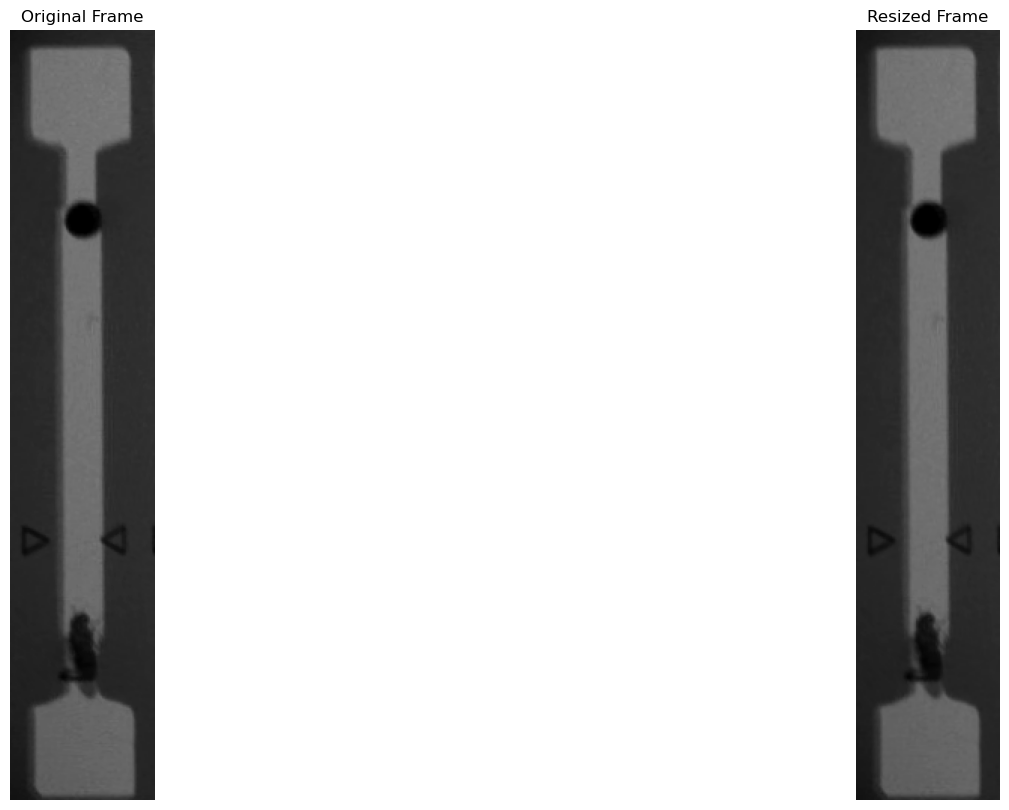

In [84]:
# Assuming frame is already defined and is a numpy array
frame_cpu = frame  # Keep the original frame for comparison

print(f"Frame shape: {frame.shape}")

# Upload the frame to the GPU
frame_gpu = cv2.cuda_GpuMat()
frame_gpu.upload(frame)

# Test the resize function on the GPU and display the result side by side with the original frame
resize_framed_gpu = resize_frame_gpu(frame_gpu, 96, 516)

# Convert the resized frame to a numpy array for plotting
resized_frame_cpu = resize_framed_gpu.download()

# Plot the original and resized frames side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Original Frame")
axs[0].axis("off")

axs[1].imshow(resized_frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Resized Frame")
axs[1].axis("off")

plt.show()

# Histogram stretching

In [597]:
def histogram_stretching_gpu(gpu_image):
    # Convert to grayscale if necessary
    if gpu_image.channels() == 3:
        gray_gpu_frame = cv2.cuda.cvtColor(gpu_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_gpu_frame = gpu_image

    if gray_gpu_frame.empty():
        print("Error: gray_gpu_frame is empty after conversion.")
        return None

    # Create a destination GpuMat for the normalized result with the same size and type as the input
    stretched_image = gray_gpu_frame
    
    print(f"type of gray_gpu_frame: {type(gray_gpu_frame)}")
    
    print("type of stretched_image: ", type(stretched_image))

    # Perform histogram stretching
    cv2.cuda.normalize(src = gray_gpu_frame, dst = stretched_image, alpha= 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = -1)

    return stretched_image


type of gray_gpu_frame: <class 'cv2.cuda.GpuMat'>
type of stretched_image:  <class 'cv2.cuda.GpuMat'>


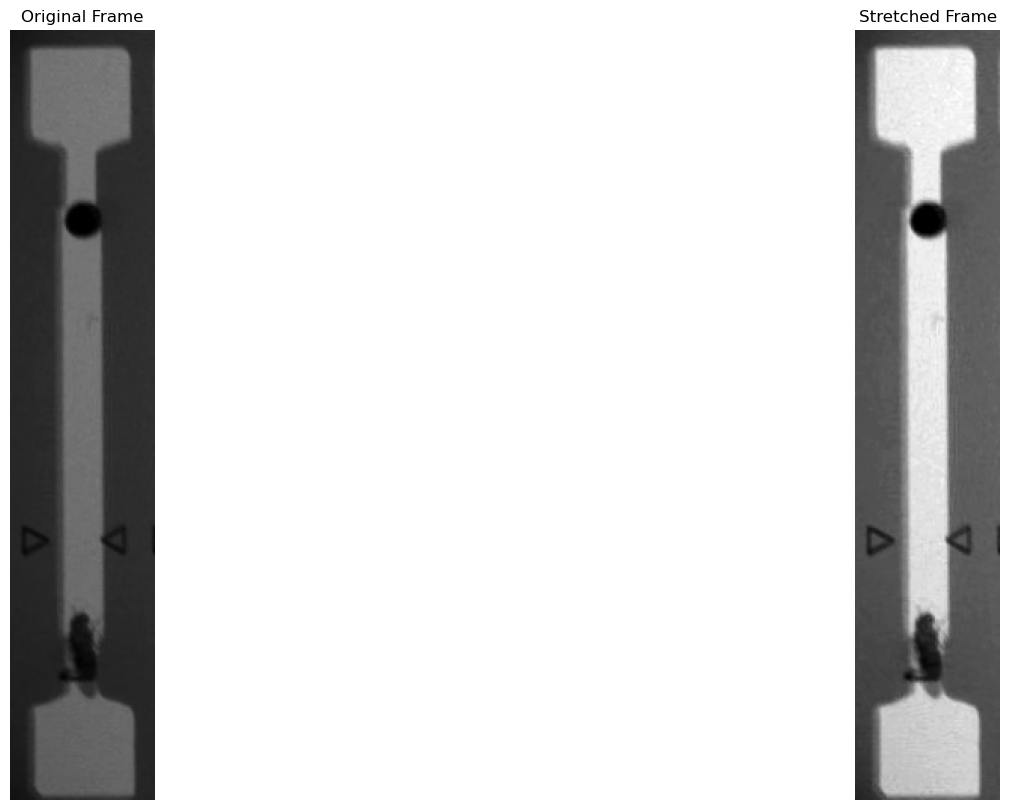

In [86]:
# Test the histogram stretching function on the GPU and display the result side by side with the original frame

# Assuming frame is already defined and is a numpy array
frame_gpu = cv2.cuda_GpuMat()
frame_gpu.upload(frame)

# Test the histogram stretching function on the GPU
stretched_frame_gpu = histogram_stretching_gpu(frame_gpu)

# Convert the stretched frame to a numpy array for plotting
stretched_frame_cpu = stretched_frame_gpu.download()

# Plot the original and stretched frames side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(frame, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Original Frame")
axs[0].axis("off")

axs[1].imshow(stretched_frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Stretched Frame")
axs[1].axis("off")

plt.show()

# Binarising

In [598]:
def binarise_gpu(frame_gpu):
    """Detect the corridors in a frame using Otsu thresholding on the CPU."""
    # Download the frame to CPU
    frame_cpu = frame_gpu.download()

    # Convert to grayscale if needed and apply Otsu thresholding
    if len(frame_cpu.shape) == 3:  # Convert to grayscale
        frame_cpu = cv2.cvtColor(frame_cpu, cv2.COLOR_BGR2GRAY)

    _, binary_cpu = cv2.threshold(
        frame_cpu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Perform morphological closing on the CPU
    kernel = np.ones((60, 20), np.uint8)  # Kernel for closing
    closing_cpu = cv2.morphologyEx(binary_cpu, cv2.MORPH_CLOSE, kernel)

    # Convert the binary image back to GPU
    closing_gpu = cv2.cuda_GpuMat()
    closing_gpu.upload(closing_cpu)

    return closing_gpu

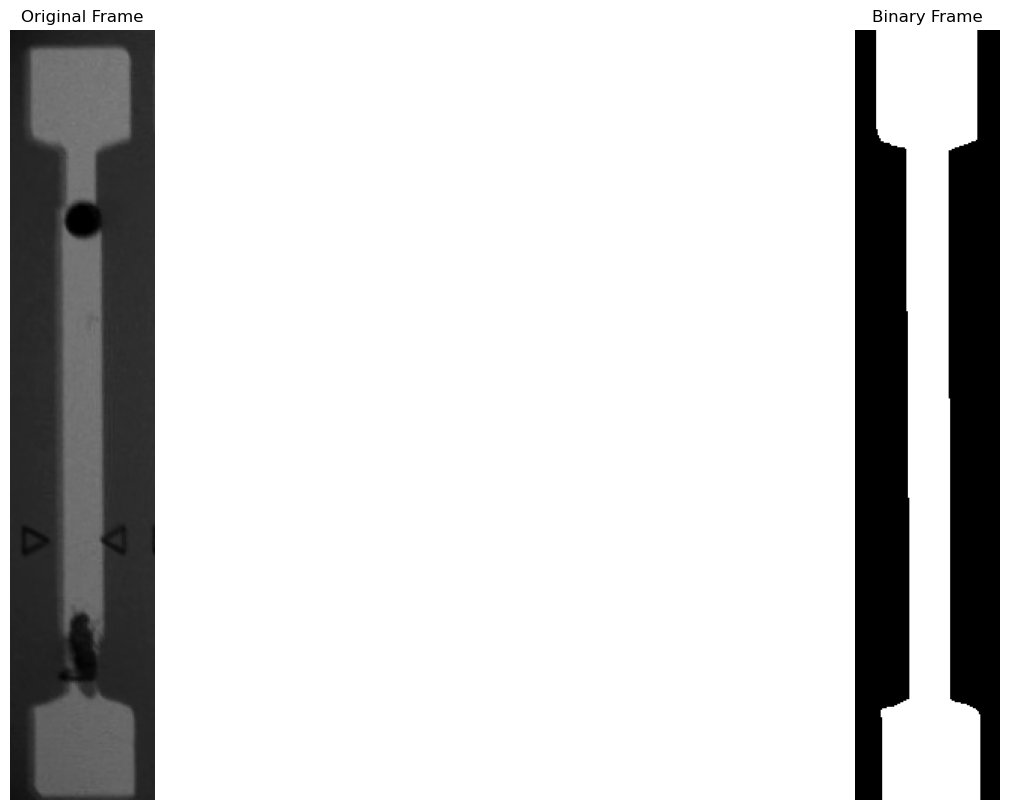

In [261]:
# Test the binarization function on the GPU and display the result side by side with the original frame

# Assuming frame is already defined and is a numpy array

# Upload the frame to the GPU
frame_gpu = cv2.cuda_GpuMat()
frame_gpu.upload(frame)

# Test the binarization function on the GPU

binary_frame_gpu = binarise_gpu(frame_gpu)

# Convert the binary frame to a numpy array for plotting

binary_frame_cpu = binary_frame_gpu.download()

# Plot the original and binary frames side by side

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(frame, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Original Frame")
axs[0].axis("off")

axs[1].imshow(binary_frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Binary Frame")
axs[1].axis("off")

plt.show()

Unique values in binary image: [  0 255]


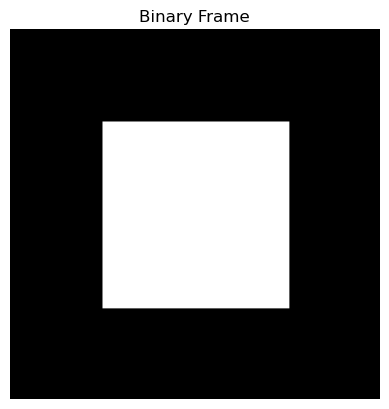

Data type of labels: int32
Shape of labels: (200, 200)


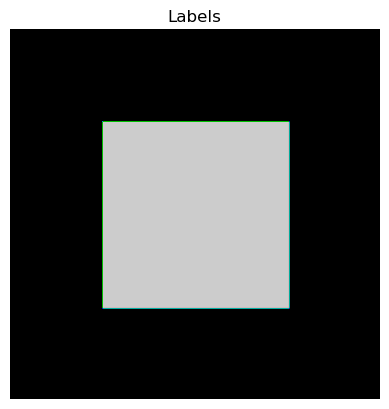

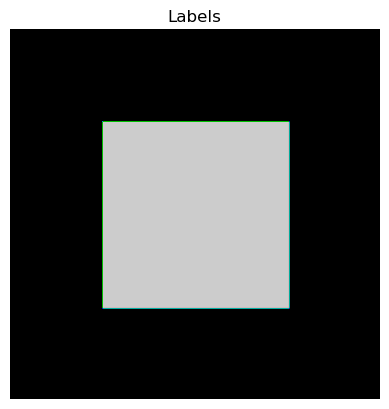

In [132]:
def create_arena_mask_gpu(binary_frame_gpu):
    """Create a mask that keeps only the area inside the detected arena using GPU."""
    # Check if binary_frame_gpu is populated
    if binary_frame_gpu.empty():
        print("Error: binary_frame_gpu is empty.")
        return None

    # Ensure the input is a binary image
    if binary_frame_gpu.channels() != 1:
        print("Error: Input image must be a single-channel binary image.")
        return None

    # Download binary frame to CPU to check unique values
    binary_frame_cpu = binary_frame_gpu.download()
    unique_values = np.unique(binary_frame_cpu)
    print("Unique values in binary image:", unique_values)

    # Check if the binary image is valid (0 and 255)
    if not np.all(np.isin(unique_values, [0, 255])):
        print("Error: Input image is not a valid binary image.")
        return None

    # Visualize the binary image
    plt.imshow(binary_frame_cpu, cmap="gray")
    plt.title("Binary Frame")
    plt.axis("off")
    plt.show()

    # Create the destination labels image
    labels_gpu = cv2.cuda.GpuMat(binary_frame_gpu.size(), cv2.CV_32S)

    # Find connected components on the GPU
    try:
        num_labels = cv2.cuda.connectedComponents(binary_frame_gpu, labels_gpu, connectivity=8, ltype=cv2.CV_32S)
    except Exception as e:
        print(f"Error during connectedComponents: {e}")
        return None

    # Download labels to CPU
    labels = labels_gpu.download()

    # Check if labels are empty or None
    if labels is None or labels.size == 0:
        print("Error: labels is None or empty after download.")
        return None

    # Debug: Check data types and shape
    print("Data type of labels:", labels.dtype)
    print("Shape of labels:", labels.shape)

    # Visualize the labels
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("Labels")
    plt.axis("off")
    plt.show()

    return labels_gpu

# Example usage
# Create a simple binary image for testing
binary_frame_cpu = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(binary_frame_cpu, (50, 50), (150, 150), 255, -1)  # Create a filled rectangle

binary_frame_gpu = cv2.cuda.GpuMat()
binary_frame_gpu.upload(binary_frame_cpu)

# Test the create_arena_mask_gpu function on the GPU
labels_gpu = create_arena_mask_gpu(binary_frame_gpu)

if labels_gpu is not None:
    labels_cpu = labels_gpu.download()
    plt.imshow(labels_cpu, cmap="nipy_spectral")
    plt.title("Labels")
    plt.axis("off")
    plt.show()
else:
    print("Error: labels_gpu is None.")

Unique values in binary image: [  0 255]


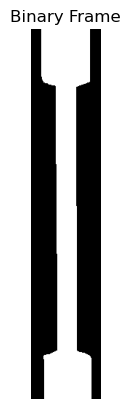

Data type of labels: int32
Shape of labels: (512, 96)


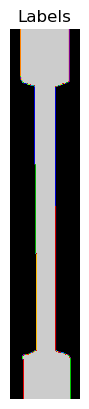

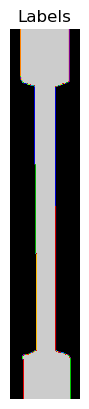

In [135]:
binary_frame_gpu = cv2.cuda.GpuMat()
binary_frame_gpu.upload(binary_frame_cpu)

# Test the create_arena_mask_gpu function on the GPU
labels_gpu = create_arena_mask_gpu(binary_frame_gpu)

if labels_gpu is not None:
    labels_cpu = labels_gpu.download()
    plt.imshow(labels_cpu, cmap="nipy_spectral")
    plt.title("Labels")
    plt.axis("off")
    plt.show()
else:
    print("Error: labels_gpu is None.")

In [113]:
# Test the arena mask creation function on the GPU and display the result side by side with the original frame

# Assuming frame is already defined and is a numpy array

# Upload the binary frame to the GPU
binary_frame_gpu = cv2.cuda_GpuMat()
binary_frame_gpu.upload(binary_frame_cpu)

# Test the arena mask creation function on the GPU
arena_mask_gpu = create_arena_mask_gpu(binary_frame_gpu)


Error: labels_gpu is empty after connectedComponents.


In [111]:

# Convert the arena mask to a numpy array for plotting
arena_mask_cpu = arena_mask_gpu.download()

# Plot the original and arena mask frames side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(binary_frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Binary Frame")
axs[0].axis("off")

axs[1].imshow(arena_mask_cpu, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Arena Mask")
axs[1].axis("off")

plt.show()

AttributeError: 'NoneType' object has no attribute 'download'

Number of labels: 2
Labels shape: (512, 96)


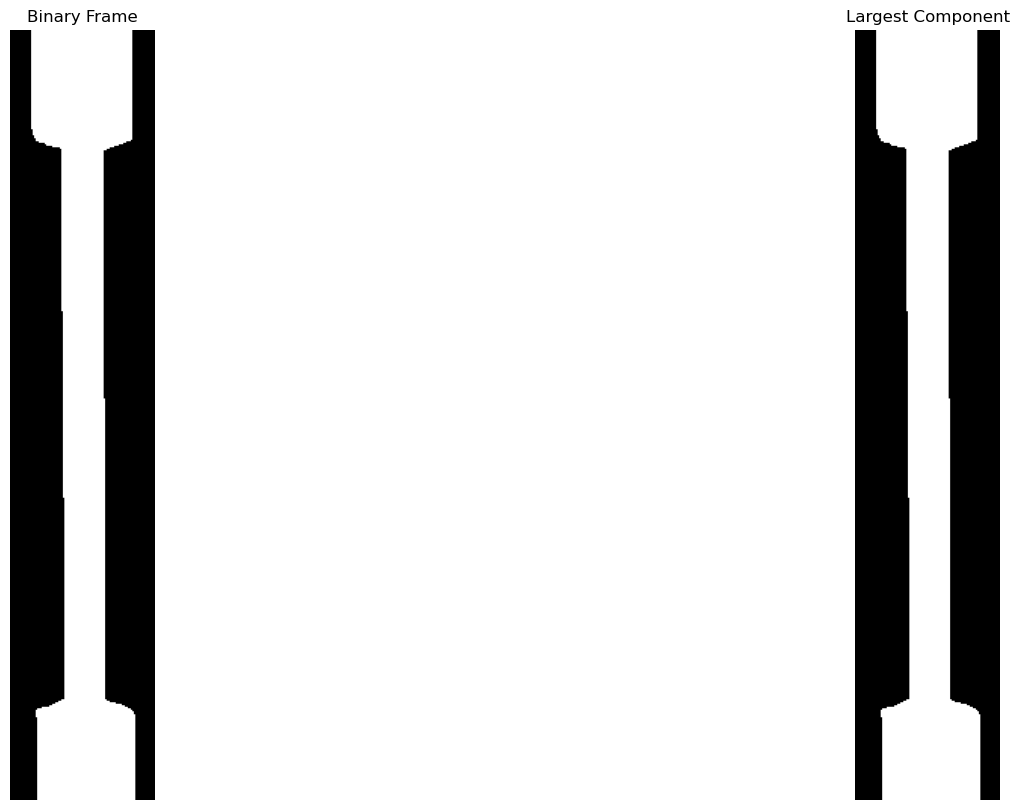

In [120]:
# Test the regular connected components function on the CPU and display the result

# Assuming binary_frame_cpu is already defined and is a numpy array

# Find connected components on the CPU
num_labels, labels_cpu = cv2.connectedComponents(binary_frame_cpu, connectivity=8, ltype=cv2.CV_32S)

# Debug: Check the number of labels and the labels array
print(f"Number of labels: {num_labels}")
print(f"Labels shape: {labels_cpu.shape}")

# Subset to get only the largest component
largest_component = np.zeros_like(labels_cpu)
largest_component[labels_cpu == 1] = 255

# Plot the binary image and the largest component
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(binary_frame_cpu, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Binary Frame")
axs[0].axis("off")

axs[1].imshow(largest_component, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Largest Component")
axs[1].axis("off")

plt.show()


Shape of frame_cpu: (512, 96, 3)
Data type of frame_cpu: uint8
Shape of largest_component: (512, 96)
Data type of largest_component: int32


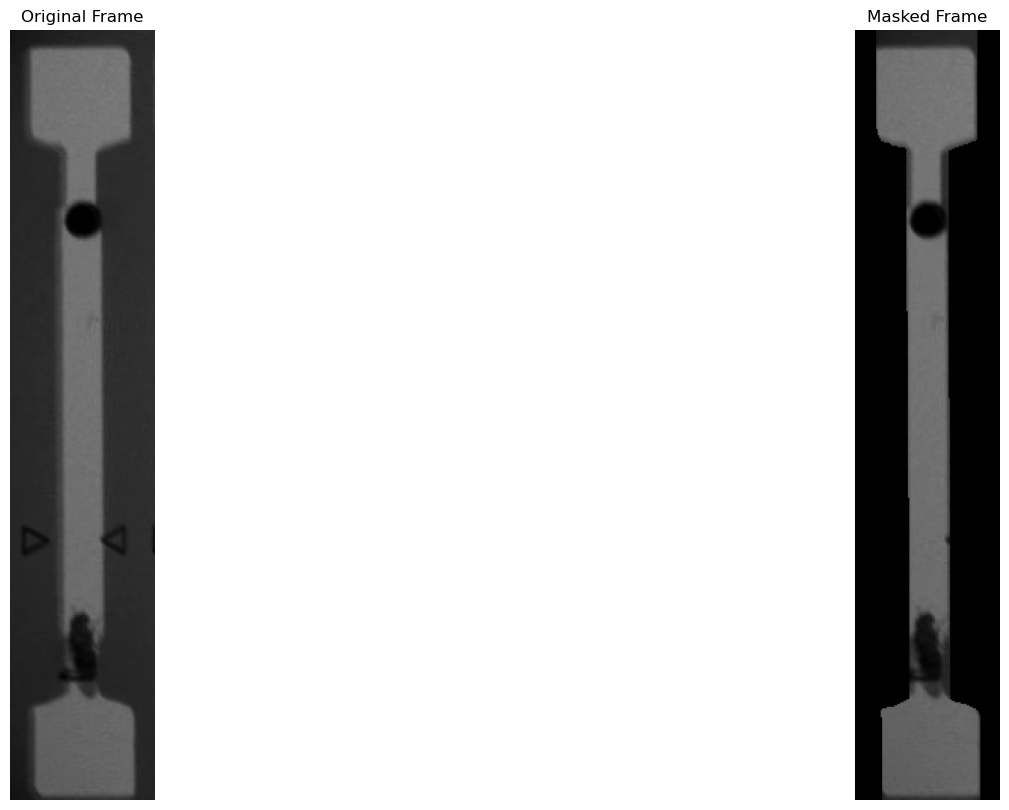

In [123]:
# Check the shapes and data types
print("Shape of frame_cpu:", frame_cpu.shape)
print("Data type of frame_cpu:", frame_cpu.dtype)
print("Shape of largest_component:", largest_component.shape)
print("Data type of largest_component:", largest_component.dtype)

# Ensure largest_component is a binary mask with the same size as frame_cpu
if largest_component.dtype != np.uint8:
    largest_component = largest_component.astype(np.uint8)

if frame_cpu.shape[:2] != largest_component.shape:
    print("Error: frame_cpu and largest_component must have the same dimensions.")
else:
    # Mask the frame with the largest component
    masked_frame_cpu = cv2.bitwise_and(frame_cpu, frame_cpu, mask=largest_component)

    # Plot the original frame and the masked frame side by side
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].imshow(frame_cpu, cmap="gray", vmin=0, vmax=255)
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    axs[1].imshow(masked_frame_cpu, cmap="gray", vmin=0, vmax=255)
    axs[1].set_title("Masked Frame")
    axs[1].axis("off")

    plt.show()

In [267]:
def create_arena_mask_gpu(binary_frame_gpu):
    """Create a mask that keeps only the area inside the detected arena using GPU."""
    # Check if binary_frame_gpu is populated
    if binary_frame_gpu.empty():
        print("Error: binary_frame_gpu is empty.")
        return None

    # Ensure the input is a binary image
    if binary_frame_gpu.channels() != 1:
        print("Error: Input image must be a single-channel binary image.")
        return None

    # Download binary frame to CPU to check unique values
    binary_frame_cpu = binary_frame_gpu.download()
    unique_values = np.unique(binary_frame_cpu)
    print("Unique values in binary image:", unique_values)

    # Check if the binary image is valid (0 and 255)
    if not np.all(np.isin(unique_values, [0, 255])):
        print("Error: Input image is not a valid binary image.")
        return None

    # Create the destination labels image
    labels_gpu = cv2.cuda.GpuMat(binary_frame_gpu.size(), cv2.CV_32S)

    # Find connected components on the GPU
    try:
        num_labels = cv2.cuda.connectedComponents(binary_frame_gpu, labels_gpu, connectivity=8, ltype=cv2.CV_32S)
    except Exception as e:
        print(f"Error during connectedComponents: {e}")
        return None

    # Download labels to CPU
    labels = labels_gpu.download()

    # Check if labels are empty or None
    if labels is None or labels.size == 0:
        print("Error: labels is None or empty after download.")
        return None

    # Debug: Check data types and shape
    print("Data type of labels:", labels.dtype)
    print("Shape of labels:", labels.shape)

    # Find the largest connected component
    unique, counts = np.unique(labels, return_counts=True)
    component_sizes = dict(zip(unique, counts))
    
    # Get the label of the largest component (ignore background label 0)
    largest_label = max(component_sizes, key=lambda x: component_sizes[x] if x != 0 else -1)

    # Create a mask for the largest component
    largest_component_mask = np.zeros_like(labels, dtype=np.uint8)
    largest_component_mask[labels == largest_label] = 255

    return largest_component_mask  # Return the largest component mask instead of labels_gpu


Unique values in binary image: [  0 255]
Data type of labels: int32
Shape of labels: (512, 96)


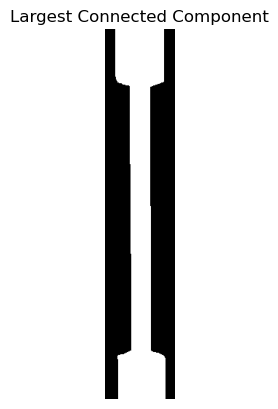

Unique values in binary image: [  0 255]
Data type of labels: int32
Shape of labels: (512, 96)


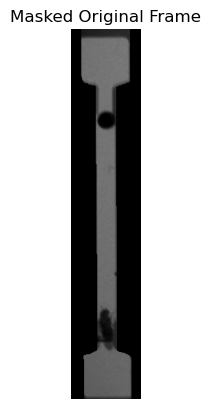

In [269]:
# Try this mask on the frame
def apply_mask_to_frame(original_frame, mask):
    """Apply the mask to the original frame."""
    # Check if original_frame and mask are populated
    if original_frame is None or mask is None:
        print("Error: original_frame or mask is None.")
        return None

    # Ensure the mask is binary (0 and 255)
    if not np.all(np.isin(mask, [0, 255])):
        print("Error: Mask is not binary.")
        return None

    # Apply the mask using element-wise multiplication
    masked_frame = cv2.bitwise_and(original_frame, original_frame, mask=mask)

    return masked_frame

# Example usage

# Upload the binary image to GPU
binary_frame_gpu = cv2.cuda.GpuMat()
binary_frame_gpu.upload(binary_frame_cpu)


# Test the create_arena_mask_gpu function on the GPU
largest_component_mask = create_arena_mask_gpu(binary_frame_gpu)

if largest_component_mask is not None:
    # Apply the mask to the original binary frame
    masked_frame = apply_mask_to_frame(frame_cpu, largest_component_mask)

    # Visualize the masked frame
    plt.imshow(masked_frame, cmap="gray")
    plt.title("Masked Original Frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: largest_component_mask is None.")


Actually, don't need to have create_mask ran on GPU as it's only done once in the video

# Create mask on CPU and apply it on GPU

In [619]:
template_width=96
template_height=516

In [620]:
# Enusre that the frame_cpu is grayscale, 1 channel
if len(frame_cpu.shape) == 3:
    print("Converting to grayscale")
    frame_cpu = cv2.cvtColor(frame_cpu, cv2.COLOR_BGR2GRAY)

In [621]:
def create_arena_mask(binary_frame, dilation_iterations=1,):
    """Create a mask that keeps only the area inside the detected arena."""
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    mask = np.zeros_like(binary_frame)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return dilated_mask

In [622]:
def apply_arena_mask_gpu(frame_gpu, mask, padding=True, cropping=True):
    """Apply the arena mask to the frame and optionally crop/pad the result using GPU."""
    
    mask_gpu = cv2.cuda_GpuMat()
    mask_gpu.upload(mask)
    
    # Make a masked frame GPU with the same size as the frame
    masked_frame_gpu = cv2.cuda_GpuMat(frame_gpu.size(), cv2.CV_8UC1)

    # Ensure the mask is also CV_8UC1
    if mask_gpu.type() != cv2.CV_8UC1:
        raise ValueError("Mask must be a single-channel 8-bit image (CV_8UC1).")
    
    if frame_gpu.type() != cv2.CV_8UC1:
        raise ValueError("Frame must be a single-channel 8-bit image (CV_8UC1).")

    # Get the frame and mask sizes
    print(frame_gpu.size())
    print(mask_gpu.size())
    
    # Ensure the mask size matches the frame size
    if mask_gpu.size() != frame_gpu.size():
        raise ValueError("Mask size must match the frame size.")
    
    # Apply the mask to the frame on the GPU
    print("masking")
    masked_frame_gpu = cv2.cuda.bitwise_and(src1=frame_gpu, src2=frame_gpu, dst= masked_frame_gpu, mask=mask_gpu)
    
    #masked_frame_cpu = masked_frame_gpu.download()

    # Plot the masked frame
    #plt.imshow(masked_frame_cpu, cmap="gray")
    
    print("masked frame size:", masked_frame_gpu.size())

    # Get the actual dimensions
    size = masked_frame_gpu.size()
    rows = size[1]
    cols = size[0]

    # Define cropping limits
    minY = 74
    maxY = rows # Should be template_height but for testing purposes we use the frame height
    minX = 0
    maxX = cols # Same: template_width

    # Validate cropping dimensions
    if minY < 0 or maxY > rows:
        raise ValueError(f"Invalid row range: {minY}, {maxY} for total rows: {rows}")
    if minX < 0 or maxX > cols:
        raise ValueError(f"Invalid column range: {minX}, {maxX} for total cols: {cols}")

    print("cropping")
    if cropping:
        # Crop using the slice method with GpuMat
        cropped_frame = masked_frame_gpu.rowRange(minY, maxY).colRange(minX, maxX)
    else:
        cropped_frame = masked_frame_gpu


    print("padding")
    if padding:
        
        padded_frame = cv2.cuda.copyMakeBorder(
            cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
    else:
        padded_frame = cropped_frame
        
    # Plot side by side the masked, cropped and padded frames
    masked_frame_cpu = masked_frame_gpu.download()
    cropped_frame_cpu = cropped_frame.download()
    padded_frame_cpu = padded_frame.download()
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    
    axs[0].imshow(masked_frame_cpu, cmap="gray", vmin=0, vmax=255)
    axs[0].set_title("Masked Frame")
    axs[0].axis("off")
    
    axs[1].imshow(cropped_frame_cpu, cmap="gray", vmin=0, vmax=255)
    axs[1].set_title("Cropped Frame")
    axs[1].axis("off")
    
    axs[2].imshow(padded_frame_cpu, cmap="gray", vmin=0, vmax=255)
    axs[2].set_title("Padded Frame")
    axs[2].axis("off")
    

    return padded_frame

(96, 512)
(96, 512)
masking
masked frame size: (96, 512)
cropping
padding


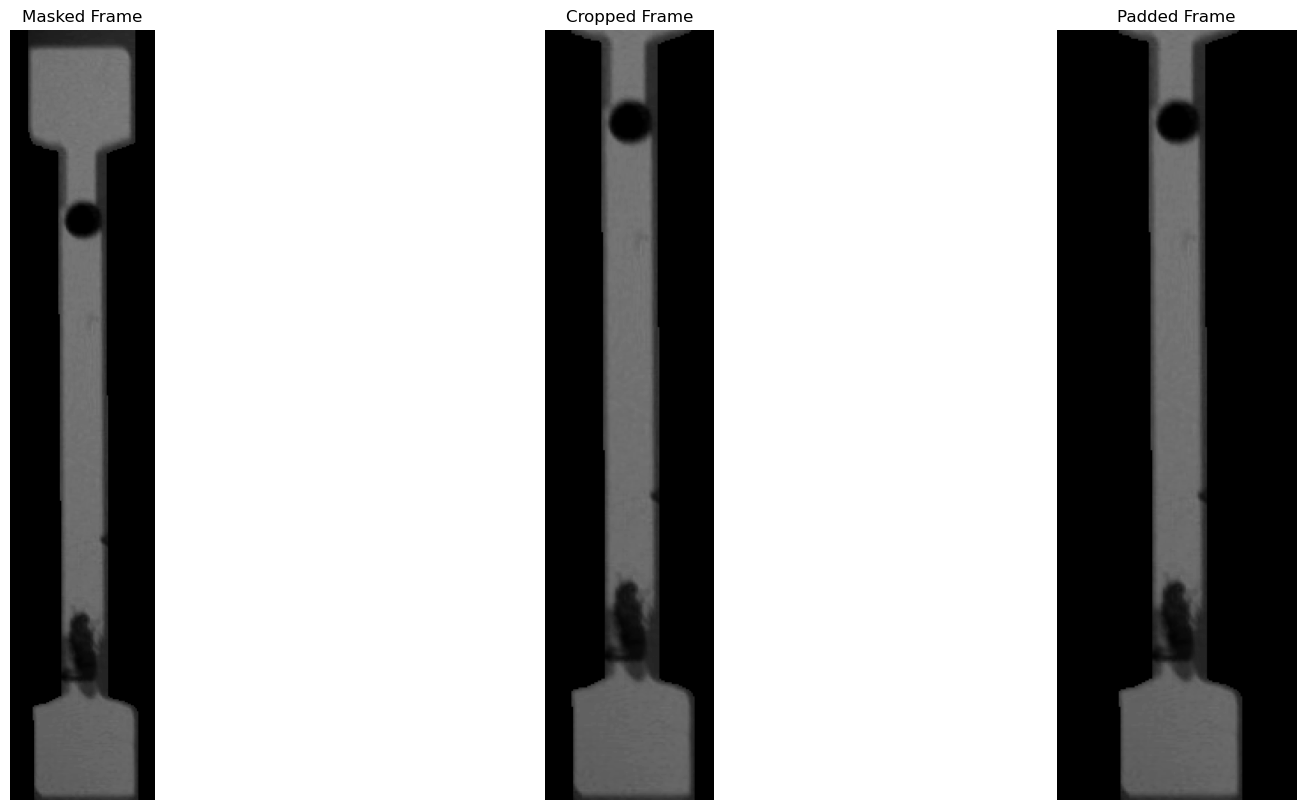

In [595]:
# Example usage
# Assuming frame_cpu and mask_cpu are already defined and are numpy arrays
frame_gpu = cv2.cuda_GpuMat()
frame_gpu.upload(frame_cpu.astype(np.uint8))

mask_gpu = create_arena_mask(binary_frame_cpu)

# Apply the arena mask on the GPU
padded_frame_gpu = apply_arena_mask_gpu(frame_gpu, mask_gpu)

# Download the result to CPU for visualization or further processing
# padded_frame_cpu = padded_frame_gpu.download()
# plt.title("Padded Frame")
# plt.axis("off")
# plt.show()

# Whole processing together

In [623]:
# Regular binarization + mask creation

def resize_frame(frame, width, height):
    """Resize the frame to the given width and height."""
    return cv2.resize(frame, (width, height))


def histogram_stretching(frame):
    """Enhance contrast using histogram stretching."""
    min_val, max_val = np.min(frame), np.max(frame)
    if max_val > min_val:
        return np.clip((frame - min_val) / (max_val - min_val) * 255, 0, 255).astype(
            np.uint8
        )
    return frame


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((60, 20), np.uint8)  # Smaller kernel to avoid losing details
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing

In [624]:
# Get a frame from the list

frame = frames[21]

# ENsure that the frame is grayscale
if len(frame.shape) == 3:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

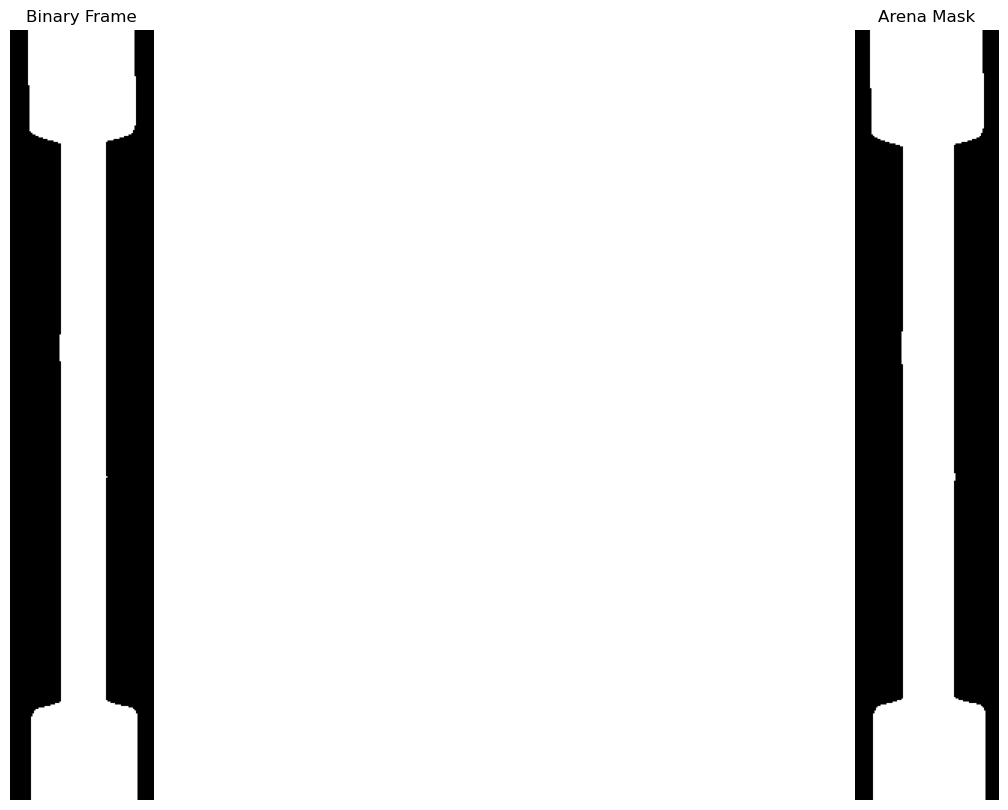

In [630]:
# Resize, stretch and binarize the frame

resized_frame = resize_frame(frame, template_width, template_height)

stretched_frame = histogram_stretching(resized_frame)

binary_frame = binarise(stretched_frame)

# Create the arena mask

arena_mask = create_arena_mask(binary_frame, dilation_iterations=1)

# plot the binary frame and the mask

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(binary_frame, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Binary Frame")
axs[0].axis("off")

axs[1].imshow(arena_mask, cmap="gray", vmin=0, vmax=255)
axs[1].set_title("Arena Mask")
axs[1].axis("off")

plt.show()

In [631]:
# Now load the frame to the GPU

frame_gpu = cv2.cuda_GpuMat()
frame_gpu.upload(frame)

# Resize and stretch the frame on the GPU

resized_frame_gpu = resize_frame_gpu(frame_gpu, template_width, template_height)

stretched_frame_gpu = histogram_stretching_gpu(resized_frame_gpu)

Resizing frame to dimensions: (96, 516)
Resized frame to dimensions: (96, 516)
type of gray_gpu_frame: <class 'cv2.cuda.GpuMat'>
type of stretched_image:  <class 'cv2.cuda.GpuMat'>


(96, 516)
(96, 516)
masking
masked frame size: (96, 516)
cropping
padding


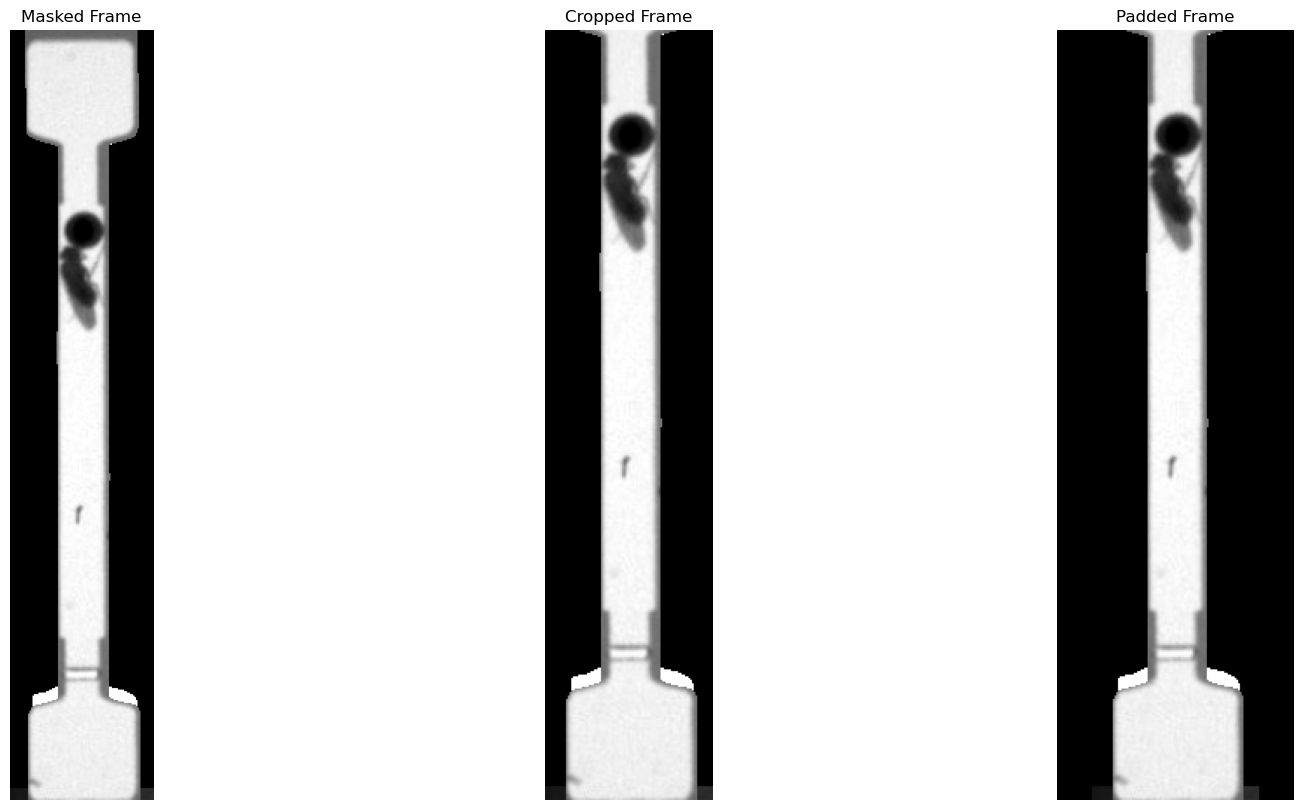

In [632]:
# Apply the arena mask to the stretched frame on the GPU

padded_frame_gpu = apply_arena_mask_gpu(stretched_frame_gpu, arena_mask)

# Download the padded frame to the CPU for visualization

padded_frame_cpu = padded_frame_gpu.download()
